# Environmental Influence on BC/EC Relationship

This notebook corresponds to the _Environmental Influence on Measurements_ section of the final report.

This notebook investigates how atmospheric components, particularly secondary aerosols and mineral dust, affect the relationship between Black Carbon (BC) and Elemental Carbon (EC). It includes:

- Analysis of secondary aerosol impact using CAMx-modeled concentrations (OA, SO₄²⁻, NO₃⁻, NH₄⁺).
- Regression modeling (polynomial, splines) to explore the effect of aerosol/EC ratios on the BC/EC relationship.
- Assessment of dust influence, including normalization and log-scaling, and correlation analyses to confirm statistical significance.

In [116]:
import pandas as pd
import numpy as np

# Load the DataFrame
df = pd.read_csv("dataset/df_merged_20250512.csv")

# Drop unnecessary columns
cols_to_drop = [
    'Unnamed: 0', 'agriculture_b500', 'airports_b500', 'barren_b500', 'imd_b500',
    'industrial_b500', 'industrial_transport_b500', 'natural_green_b500',
    'population_density_b500', 'ports_b500', 'roads_rails_b500', 'snow_ice_b500',
    'transport_b500', 'urban_fabric_b500', 'urban_green_b500', 'water_b500',
    'wetlands_b500', 'road_class_1_700', 'road_class_2_50', 'road_class_1_500',
    'road_class_3_50', 'road_class_2_400', 'road_class_1_100', 'road_class_2_700',
    'road_class_3_100', 'road_class_2_500', 'road_class_1_400', 'road_class_3_400',
    'road_class_1_2000', 'road_class_3_10000', 'road_class_1_300', 'road_class_3_500',
    'road_class_2_2000', 'road_class_3_300', 'road_class_2_200', 'road_class_1_200',
    'road_class_1_5000', 'road_class_1_50', 'road_class_3_200', 'road_class_3_5000',
    'road_class_2_300', 'road_class_2_5000', 'road_class_3_2000', 'road_class_2_100',
    'road_class_3_700', 'road_class_2_10000', 'road_class_1_10000'
]
df.drop(columns=cols_to_drop, inplace=True)

# Create EC column based on EC_BC
df['EC'] = np.where(df['EC_BC'] == 0, df['EC_BC_merged'], np.nan)
df['BC'] = np.where(df['EC_BC'] == 1, df['EC_BC_merged'], np.nan)

# Create Instrument_EC and Instrument_BC columns
df['Instrument_EC'] = np.where(df['EC_BC'] == 0, df['Instrument'], np.nan)
df['Instrument_BC'] = np.where(df['EC_BC'] == 1, df['Instrument'], np.nan)

# Drop redundant columns
df.drop(columns=['Instrument', 'EC_BC', 'EC_BC_merged'], inplace=True)

# Rename Date to Datetime
df.rename(columns={'Date': 'Datetime'}, inplace=True)

# Create camx_oa as the sum of camx_bboa, camx_hoa, and camx_ooa
df['camx_oa'] = df['camx_bboa'] + df['camx_hoa'] + df['camx_ooa']

# Compute secondary aerosol sum
df['aerosols'] = df['camx_oa'] + df['camx_no3'] + df['camx_so4'] + df['camx_nh4']

# Reorder columns
desired_order = [
    'Station_name', 'ID', 'Latitude', 'Longitude', 'Datetime',
    'BC', 'EC', 'Protocol', 'Instrument_EC', 'Instrument_BC', 'MAC', 'Size_cut', 
    'C_value', 'H_value', 'Flag_MCH', 'DOW', 'CLC', 'agriculture_b1000', 'airports_b1000', 
    'barren_b1000', 'imd_b1000', 'industrial_b1000', 'industrial_transport_b1000', 
    'natural_green_b1000', 'population_density_b1000', 'ports_b1000', 'roads_rails_b1000', 
    'snow_ice_b1000', 'transport_b1000', 'urban_fabric_b1000', 'urban_green_b1000', 
    'water_b1000', 'wetlands_b1000', 'road_class_1_1000', 'road_class_2_1000', 'road_class_3_1000', 
    'dust', 'camx_oa', 'camx_no3', 'camx_so4', 'camx_nh4', 'camx_cl', 'camx_ec', 'camx_na', 
    'camx_fprm', 'camx_no', 'camx_no2', 'camx_co', 'camx_nh3', 'camx_hno3', 'camx_isop', 'camx_o3',
    'camx_ooa', 'camx_bboa', 'camx_hoa', 'camx_pas', 'camx_pbis', 'camx_pbbs',
    'camx_prts', 'Cu_CAMx', 'aerosols', 'elevation_1k', 'T2', 'RH', 'Press', 'WS', 'WD', 'PBLH'
]
df = df[desired_order]

# Clean Protocol values
df['Protocol'] = df['Protocol'].replace(['999.9', 999.9, np.nan], 'UNKNOWN')
df['Protocol'] = df['Protocol'].replace({'EUSAAR1': 'EUSAAR', 'EUSAAR2': 'EUSAAR'})

# Clean Instrument_EC
df['Instrument_EC'] = df['Instrument_EC'].replace(['Filters', 'AE33', 'unknown', np.nan], 'UNKNOWN')

# Clean Instrument_BC
df['Instrument_BC'] = df['Instrument_BC'].replace(to_replace=r'^AE\d*$', value='AE', regex=True)
df['Instrument_BC'] = df['Instrument_BC'].replace(['LVol_Filters', 'Filters', 'unknown', np.nan], 'UNKNOWN')
df['Instrument_BC'] = df['Instrument_BC'].replace(['PSAP-ITM', 'MWAA'], 'MAAP')

# Clean Size_cut
df['Size_cut'] = df['Size_cut'].replace([0.0, 999.9, '999.9', np.nan], 999.0)

# Clean MAC
df['MAC'] = df['MAC'].replace([999, 999.0, '999.0', 999.00, np.nan], 999.0).round(1)

# Clean C_value
df['C_value'] = df['C_value'].replace([999, 999.0, '999.0', 999.00, np.nan], 999.0).round(1)

# Clean H_value
df['H_value'] = df['H_value'].fillna(999.0).round(1)

# Clean Flag_MCH
df['Flag_MCH'] = df['Flag_MCH'].fillna(1)

# Ensure Datetime column is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Save the cleaned and merged full DataFrame
df.to_csv("dataset/dataframe_merged.csv", index=False)

# Display result
display(df)

/var/folders/8s/fjskjb050nsf6qwhyq994z500000gn/T/ipykernel_14230/331438964.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset/df_merged_20250512.csv")


,Station_name,ID,Latitude,Longitude,Datetime,BC,EC,Protocol,Instrument_EC,Instrument_BC,...,camx_prts,Cu_CAMx,aerosols,elevation_1k,T2,RH,Press,WS,WD,PBLH
0,Passy,ID156,48.858,2.2860,2017-11-27,NaN,2.55956,EUSAAR,HVol_Filters,UNKNOWN,...,0.000,3.191,4.737,59.0,278.911,87.962,1010.114,3.092,224.191,582.945
1,Passy,ID156,48.858,2.2860,2017-11-29,NaN,1.15113,EUSAAR,HVol_Filters,UNKNOWN,...,0.000,4.922,12.005,59.0,276.396,87.404,997.284,1.988,279.446,329.632
2,Passy,ID156,48.858,2.2860,2017-11-30,NaN,1.56394,EUSAAR,HVol_Filters,UNKNOWN,...,0.000,2.414,8.898,59.0,275.433,82.329,998.649,2.731,288.078,540.150
3,Passy,ID156,48.858,2.2860,2017-12-02,NaN,1.64769,EUSAAR,HVol_Filters,UNKNOWN,...,0.007,6.083,29.314,59.0,273.144,86.966,1016.765,1.253,282.511,165.771
4,Passy,ID156,48.858,2.2860,2017-12-03,NaN,1.62449,EUSAAR,HVol_Filters,UNKNOWN,...,0.004,6.126,29.428,59.0,276.199,94.871,1016.918,1.422,247.534,173.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323970,Illmitz,ID134,47.770,16.7672,2014-03-06,2.52458,NaN,EUSAAR,UNKNOWN,AE,...,0.048,1.119,39.522,106.0,280.539,81.539,999.328,5.326,330.545,568.438
323971,Illmitz,ID134,47.770,16.7672,2014-03-07,2.75486,NaN,EUSAAR,UNKNOWN,AE,...,0.039,1.351,30.827,106.0,279.994,88.009,1003.445,3.986,303.856,276.199
323972,Illmitz,ID134,47.770,16.7672,2014-03-08,2.64310,NaN,EUSAAR,UNKNOWN,AE,...,0.097,1.256,39.634,106.0,280.835,76.937,1010.992,4.697,330.946,460.685
323973,Illmitz,ID134,47.770,16.7672,2014-03-09,2.65927,NaN,EUSAAR,UNKNOWN,AE,...,0.091,1.085,32.083,106.0,280.099,71.885,1014.323,3.376,230.360,500.542


Let's look at the average value (in µg/m³) of each component in addition to its % contribution for each aerosol concentration measurement. This allows us to answer two questions in a single figure: What is the relative share of each component in aerosols or camx_oa? And what is the average absolute value of each component?

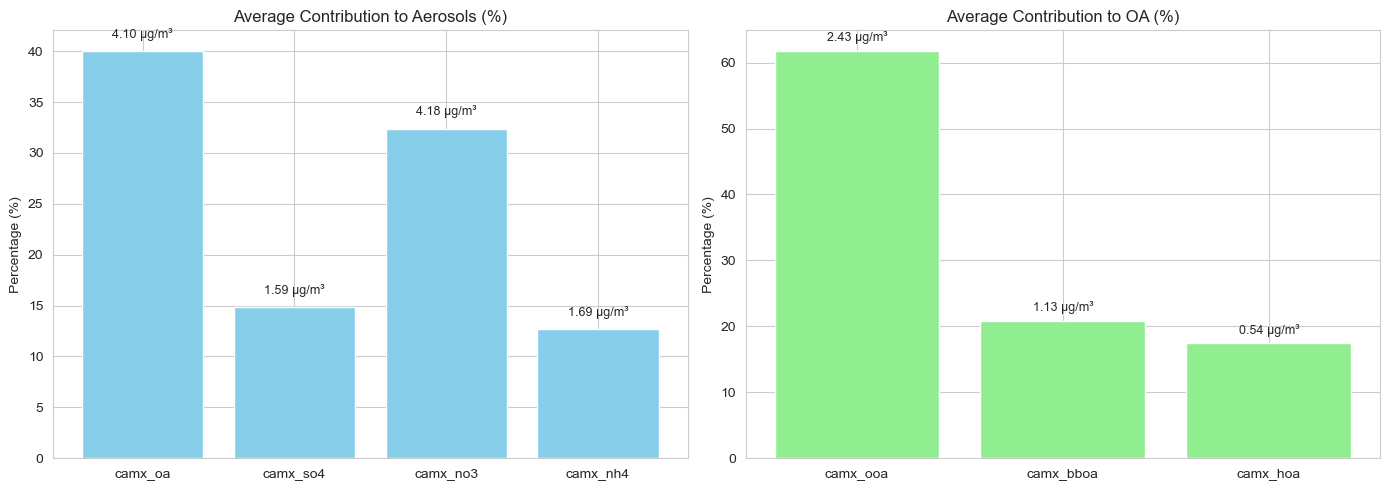

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Applied style
sns.set_style("whitegrid")

# Define component lists
aerosol_components = ['camx_oa', 'camx_so4', 'camx_no3', 'camx_nh4']
oa_components = ['camx_ooa', 'camx_bboa', 'camx_hoa']

# Calculate percentage contribution to aerosols
df_aero_ratio = df[aerosol_components].div(df['aerosols'], axis=0) * 100
mean_contrib_aero = df_aero_ratio.mean()
mean_values_aero = df[aerosol_components].mean()

# Calculate percentage contribution to camx_oa
df_oa_ratio = df[oa_components].div(df['camx_oa'], axis=0) * 100
mean_contrib_oa = df_oa_ratio.mean()
mean_values_oa = df[oa_components].mean()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Aerosols
bars1 = axes[0].bar(mean_contrib_aero.index, mean_contrib_aero.values, color='skyblue')
axes[0].set_title("Average Contribution to Aerosols (%)")
axes[0].set_ylabel("Percentage (%)")
axes[0].grid(True, axis='y')

# Annotate with absolute values
for bar, value in zip(bars1, mean_values_aero.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{value:.2f} µg/m³", ha='center', va='bottom', fontsize=9)

# Plot 2: camx_oa
bars2 = axes[1].bar(mean_contrib_oa.index, mean_contrib_oa.values, color='lightgreen')
axes[1].set_title("Average Contribution to OA (%)")
axes[1].set_ylabel("Percentage (%)")
axes[1].grid(True, axis='y')

# Annotate with absolute values
for bar, value in zip(bars2, mean_values_oa.values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{value:.2f} µg/m³", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

For a comparative analysis with outlier detection and predictive modeling, we need to aggregate the data to merge BC and EC values taken at the same station and time.

In [120]:
def merge_colocated_data(df):
    """
    Merge colocated BC and EC measurements (same station, same datetime).
    - Takes BC from one row and EC from another
    - Merges metadata: resolves strings, averages environmental columns
    """
    df_bc = df[df['BC'].notna()].copy()
    df_ec = df[df['EC'].notna()].copy()

    df_merged = pd.merge(
        df_bc,
        df_ec,
        on=['Station_name', 'Datetime'],
        suffixes=('_bc', '_ec'),
        how='inner'
    )

    def resolve_text_columns(val1, val2, missing_indicator="UNKNOWN"):
        val1_str = str(val1) if pd.notna(val1) else None
        val2_str = str(val2) if pd.notna(val2) else None
        if val1_str == missing_indicator or val1_str is None:
            return val2
        if val2_str == missing_indicator or val2_str is None:
            return val1
        if val1_str == val2_str:
            return val1
        return f"{val1}, {val2}"

    def resolve_numeric_columns(val1, val2, missing_indicator=999.0):
        if pd.isna(val1) or (isinstance(val1, (int, float)) and np.isclose(val1, missing_indicator)):
            return val2
        if pd.isna(val2) or (isinstance(val2, (int, float)) and np.isclose(val2, missing_indicator)):
            return val1
        if val1 == val2:
            return val1
        return f"{val1}, {val2}"

    def resolve_flag_mch(val1, val2):
        if pd.isna(val1) and pd.isna(val2):
            return np.nan
        if pd.isna(val1):
            return val2
        if pd.isna(val2):
            return val1
        if val1 == val2:
            return val1
        return f"{val1}, {val2}"

    # Columns to average
    avg_columns = [
        'DOW', 'CLC', 'agriculture_b1000', 'airports_b1000', 'barren_b1000', 'imd_b1000',
        'industrial_b1000', 'industrial_transport_b1000', 'natural_green_b1000',
        'population_density_b1000', 'ports_b1000', 'roads_rails_b1000', 'snow_ice_b1000',
        'transport_b1000', 'urban_fabric_b1000', 'urban_green_b1000', 'water_b1000',
        'wetlands_b1000', 'road_class_1_1000', 'road_class_2_1000', 'road_class_3_1000', 
        'dust', 'camx_oa', 'camx_no3', 'camx_so4', 'camx_nh4', 'camx_cl', 'camx_ec', 'camx_na', 
        'camx_fprm', 'camx_no', 'camx_no2', 'camx_co', 'camx_nh3', 'camx_hno3', 'camx_isop', 
        'camx_o3', 'camx_ooa', 'camx_bboa', 'camx_hoa', 'camx_pas', 'camx_pbis', 'camx_pbbs',
        'camx_prts', 'Cu_CAMx', 'aerosols', 'elevation_1k', 'T2', 'RH', 'Press', 'WS', 'WD', 'PBLH'
    ]

    averaged_data = {
        col: df_merged[[f"{col}_bc", f"{col}_ec"]].mean(axis=1)
        for col in avg_columns
    }

    df_colocated = pd.DataFrame({
        'Station_name': df_merged['Station_name'],
        'ID': df_merged['ID_bc'],
        'Latitude': df_merged['Latitude_bc'],
        'Longitude': df_merged['Longitude_bc'],
        'Datetime': df_merged['Datetime'],
        'BC': df_merged['BC_bc'],
        'EC': df_merged['EC_ec'],
        'Protocol': [resolve_text_columns(r['Protocol_bc'], r['Protocol_ec']) for _, r in df_merged.iterrows()],
        'Instrument_EC': [resolve_text_columns(r['Instrument_EC_bc'], r['Instrument_EC_ec']) for _, r in df_merged.iterrows()],
        'Instrument_BC': [resolve_text_columns(r['Instrument_BC_bc'], r['Instrument_BC_ec']) for _, r in df_merged.iterrows()],
        'MAC': [resolve_numeric_columns(r['MAC_bc'], r['MAC_ec']) for _, r in df_merged.iterrows()],
        'Size_cut': [resolve_numeric_columns(r['Size_cut_bc'], r['Size_cut_ec']) for _, r in df_merged.iterrows()],
        'C_value': [resolve_numeric_columns(r['C_value_bc'], r['C_value_ec']) for _, r in df_merged.iterrows()],
        'H_value': [resolve_numeric_columns(r['H_value_bc'], r['H_value_ec']) for _, r in df_merged.iterrows()],
        'Flag_MCH': [resolve_flag_mch(r['Flag_MCH_bc'], r['Flag_MCH_ec']) for _, r in df_merged.iterrows()]
    })

    # Add averaged columns
    for col, values in averaged_data.items():
        df_colocated[col] = values

    return df_colocated

# Execute the merging
df_colocated = merge_colocated_data(df)

# Ensure datetime format
df_colocated['Datetime'] = pd.to_datetime(df_colocated['Datetime'])

# Save the colocated-only DataFrame
df_colocated.to_csv("dataset/df_merged_colocated.csv", index=False)

# Display result
print(f"Number of colocated rows: {len(df_colocated)}")
display(df_colocated)

Number of colocated rows: 21009


,Station_name,ID,Latitude,Longitude,Datetime,BC,EC,Protocol,Instrument_EC,Instrument_BC,...,camx_prts,Cu_CAMx,aerosols,elevation_1k,T2,RH,Press,WS,WD,PBLH
0,Genova-Bolzaneto,ID332,44.4573,44.4573,2011-07-08,1.326122,1.339383,UNKNOWN,UNKNOWN,MAAP,...,1.042,0.422,9.825,101.0,293.815,82.202,975.785,2.684,126.154,390.891
1,Genova-Bolzaneto,ID332,44.4573,44.4573,2011-07-10,1.684976,1.701826,UNKNOWN,UNKNOWN,MAAP,...,0.923,0.560,12.221,101.0,294.362,78.569,978.890,1.795,124.351,258.038
2,Genova-Bolzaneto,ID332,44.4573,44.4573,2011-07-12,2.267457,2.290131,UNKNOWN,UNKNOWN,MAAP,...,1.100,0.956,11.924,101.0,297.742,58.374,976.179,1.755,130.763,327.084
3,Genova-Bolzaneto,ID332,44.4573,44.4573,2011-07-14,1.468050,1.482731,UNKNOWN,UNKNOWN,MAAP,...,0.564,0.748,9.244,101.0,295.086,65.970,972.389,2.096,220.235,500.766
4,Genova-Bolzaneto,ID332,44.4573,44.4573,2011-07-19,0.968671,0.978358,UNKNOWN,UNKNOWN,MAAP,...,0.016,0.384,1.828,101.0,289.486,82.942,965.460,2.036,183.320,336.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21004,Illmitz,ID134,47.7700,16.7672,2014-03-07,2.754860,1.064961,EUSAAR,UNKNOWN,AE,...,0.039,1.351,30.827,106.0,279.994,88.009,1003.445,3.986,303.856,276.199
21005,Illmitz,ID134,47.7700,16.7672,2014-03-08,2.643100,0.489000,EUSAAR,HVol_Filters,AE,...,0.097,1.256,39.634,106.0,280.835,76.937,1010.992,4.697,330.946,460.685
21006,Illmitz,ID134,47.7700,16.7672,2014-03-08,2.643100,0.733445,EUSAAR,UNKNOWN,AE,...,0.097,1.256,39.634,106.0,280.835,76.937,1010.992,4.697,330.946,460.685
21007,Illmitz,ID134,47.7700,16.7672,2014-03-09,2.659270,1.139278,EUSAAR,UNKNOWN,AE,...,0.091,1.085,32.083,106.0,280.099,71.885,1014.323,3.376,230.360,500.542


First let's display the distributions in each group to better undertsand our variables.

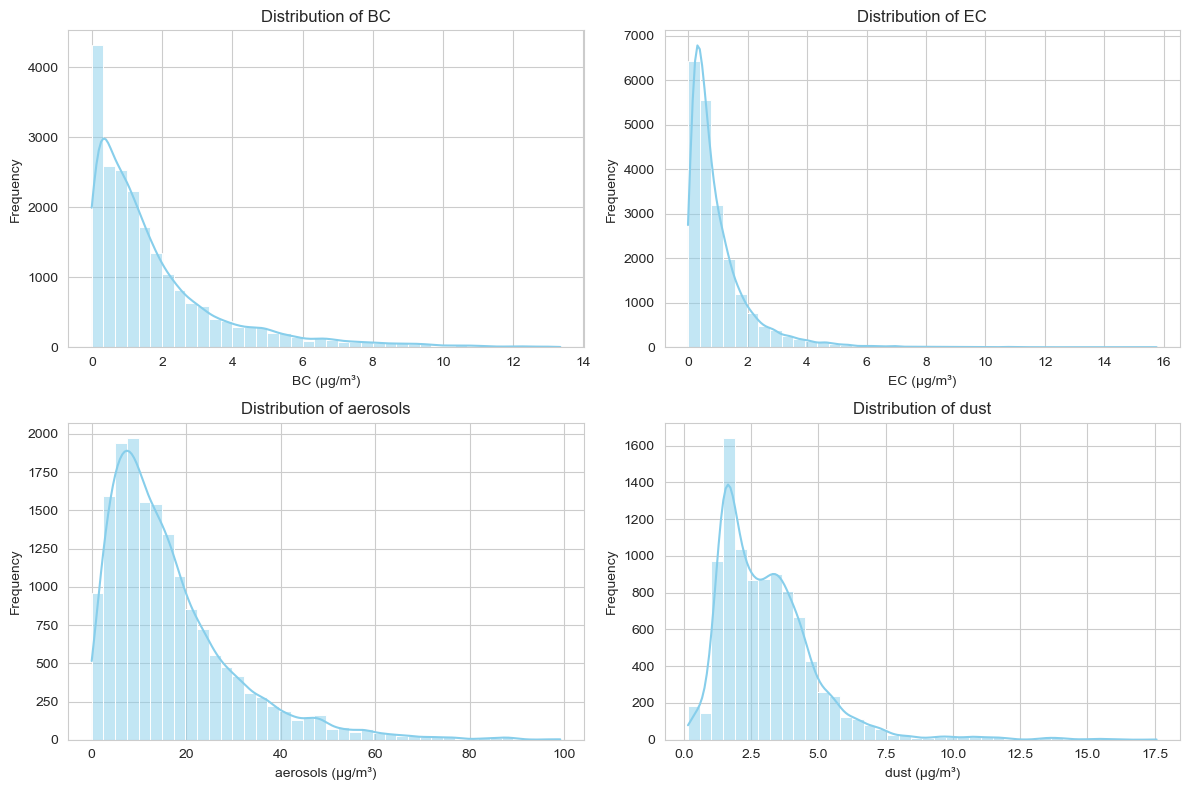

In [122]:
# List of groups to view
cols = ["BC", "EC", "aerosols", "dust"]

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(cols):
    ax = axes[i // 2, i % 2]
    sns.histplot(df_colocated[col].dropna(), kde=True, ax=ax, bins=40, color='skyblue')
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(f"{col} (µg/m³)")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

To detect outliers in our dataset, we can apply Quantile Regression, which models the conditional distribution of BC given EC at different quantiles. The model is optimized using the Pinball Loss function, which asymmetrically penalizes over- and under-predictions. This is useful to establish upper and lower bounds beyond which values are considered outliers. 

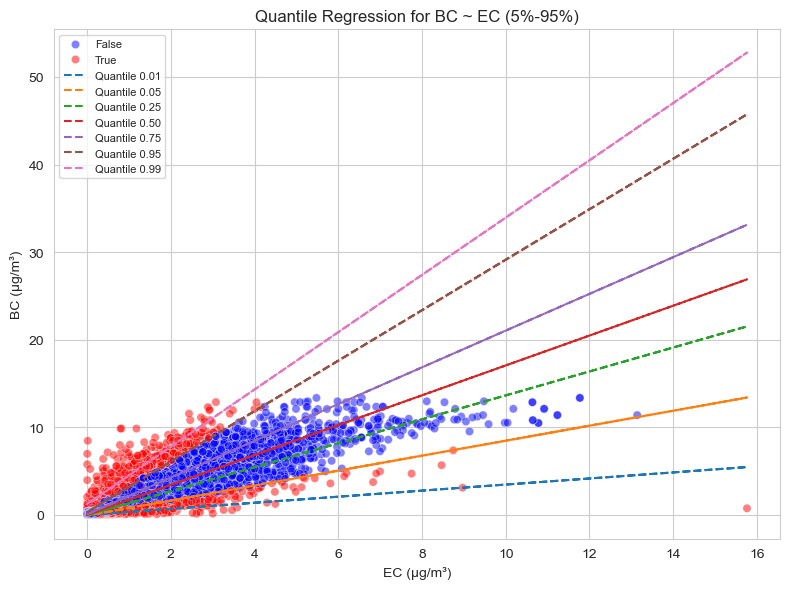

Based on 5%-95% quantile bounds:
 - Total data points analyzed: 21009
 - Number of outliers detected: 2104
Based on 1%-99% quantile bounds:
 - Total data points analyzed: 21009
 - Number of outliers detected: 422


In [124]:
import statsmodels.api as sm

# Prepare the data
df_filtered = df_colocated.dropna(subset=["BC", "EC"]).copy()
X = sm.add_constant(df_filtered["EC"])
y = df_filtered["BC"]

# Define the quantiles to calculate
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df_preds = pd.DataFrame({"EC": df_filtered["EC"]})

# Fit the quantile regressions
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    df_preds[q] = model.predict(X)

# Calculate bounds and detect outliers
df_filtered["Lower_05_95_BC"] = df_preds[0.05]
df_filtered["Upper_05_95_BC"] = df_preds[0.95]
df_filtered["Outlier_05_95_BC"] = ((df_filtered["BC"] < df_filtered["Lower_05_95_BC"]) | (df_filtered["BC"] > df_filtered["Upper_05_95_BC"]))

df_filtered["Lower_01_99_BC"] = df_preds[0.01]
df_filtered["Upper_01_99_BC"] = df_preds[0.99]
df_filtered["Outlier_01_99_BC"] = ((df_filtered["BC"] < df_filtered["Lower_01_99_BC"]) | (df_filtered["BC"] > df_filtered["Upper_01_99_BC"]))

# Display only the 5%-95% plot
plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.scatterplot(
    ax=ax, x=df_filtered["EC"], y=df_filtered["BC"],
    hue=df_filtered["Outlier_05_95_BC"], palette={True: "red", False: "blue"},
    alpha=0.5
)
for q in quantiles:
    ax.plot(df_preds["EC"], df_preds[q], linestyle="dashed", label=f"Quantile {q:.2f}")
ax.fill_between(df_preds["EC"], df_preds[0.05], df_preds[0.95], color='red', alpha=0.1)
ax.set_title("Quantile Regression for BC ~ EC (5%-95%)")
ax.set_xlabel("EC (µg/m³)")
ax.set_ylabel("BC (µg/m³)")
ax.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# Summary of outlier detection results
total_points_BC = len(df_filtered)

num_outliers_05_95_BC = df_filtered["Outlier_05_95_BC"].sum()
percent_outliers_05_95_BC = (num_outliers_05_95_BC / total_points_BC) * 100

num_outliers_01_99_BC = df_filtered["Outlier_01_99_BC"].sum()
percent_outliers_01_99_BC = (num_outliers_01_99_BC / total_points_BC) * 100

print("Based on 5%-95% quantile bounds:")
print(f" - Total data points analyzed: {total_points_BC}")
print(f" - Number of outliers detected: {num_outliers_05_95_BC}")

print("Based on 1%-99% quantile bounds:")
print(f" - Total data points analyzed: {total_points_BC}")
print(f" - Number of outliers detected: {num_outliers_01_99_BC}")

The same outlier detection method must be applied to the aerosol column as a function of EC, using a quantile regression exactly as we did for BC.

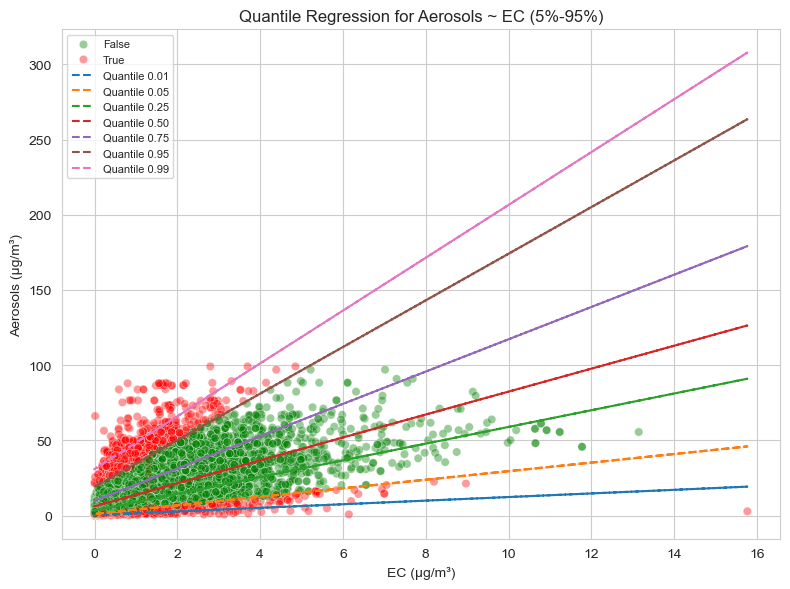

Based on 5%-95% quantile bounds:
 - Total data points analyzed: 16945
 - Number of outliers detected: 1696
Based on 1%-99% quantile bounds:
 - Total data points analyzed: 16945
 - Number of outliers detected: 341


In [126]:
# Prepare data
df_filtered = df_filtered.dropna(subset=["aerosols", "EC"]).copy()
X = sm.add_constant(df_filtered["EC"])
y = df_filtered["aerosols"]

# Quantiles to compute
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df_preds = pd.DataFrame({"EC": df_filtered["EC"]})

# Fit quantile regressions
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    df_preds[q] = model.predict(X)

# Compute bounds and outliers
df_filtered["Lower_05_95_aerosols"] = df_preds[0.05]
df_filtered["Upper_05_95_aerosols"] = df_preds[0.95]
df_filtered["Outlier_05_95_aerosols"] = (
    (df_filtered["aerosols"] < df_filtered["Lower_05_95_aerosols"]) |
    (df_filtered["aerosols"] > df_filtered["Upper_05_95_aerosols"])
)

df_filtered["Lower_01_99_aerosols"] = df_preds[0.01]
df_filtered["Upper_01_99_aerosols"] = df_preds[0.99]
df_filtered["Outlier_01_99_aerosols"] = (
    (df_filtered["aerosols"] < df_filtered["Lower_01_99_aerosols"]) |
    (df_filtered["aerosols"] > df_filtered["Upper_01_99_aerosols"])
)

# Plot result (5%-95% only)
plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.scatterplot(
    ax=ax, x=df_filtered["EC"], y=df_filtered["aerosols"],
    hue=df_filtered["Outlier_05_95_aerosols"], palette={True: "red", False: "green"},
    alpha=0.4
)
for q in quantiles:
    ax.plot(df_preds["EC"], df_preds[q], linestyle="dashed", label=f"Quantile {q:.2f}")
ax.fill_between(df_preds["EC"], df_preds[0.05], df_preds[0.95], color='red', alpha=0.1)
ax.set_title("Quantile Regression for Aerosols ~ EC (5%-95%)")
ax.set_xlabel("EC (µg/m³)")
ax.set_ylabel("Aerosols (µg/m³)")
ax.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# Summary of outlier detection results
total_points_aerosols = len(df_filtered)

num_outliers_05_95_aerosols = df_filtered["Outlier_05_95_aerosols"].sum()
percent_outliers_05_95_aerosols = (num_outliers_05_95_aerosols / total_points_aerosols) * 100

num_outliers_01_99_aerosols = df_filtered["Outlier_01_99_aerosols"].sum()
percent_outliers_01_99_aerosols = (num_outliers_01_99_aerosols / total_points_aerosols) * 100

print("Based on 5%-95% quantile bounds:")
print(f" - Total data points analyzed: {total_points_aerosols}")
print(f" - Number of outliers detected: {num_outliers_05_95_aerosols}")

print("Based on 1%-99% quantile bounds:")
print(f" - Total data points analyzed: {total_points_aerosols}")
print(f" - Number of outliers detected: {num_outliers_01_99_aerosols}")

Once again, the same outlier detection method must be applied to the dust column as a function of EC, using a quantile regression exactly as we did previously.

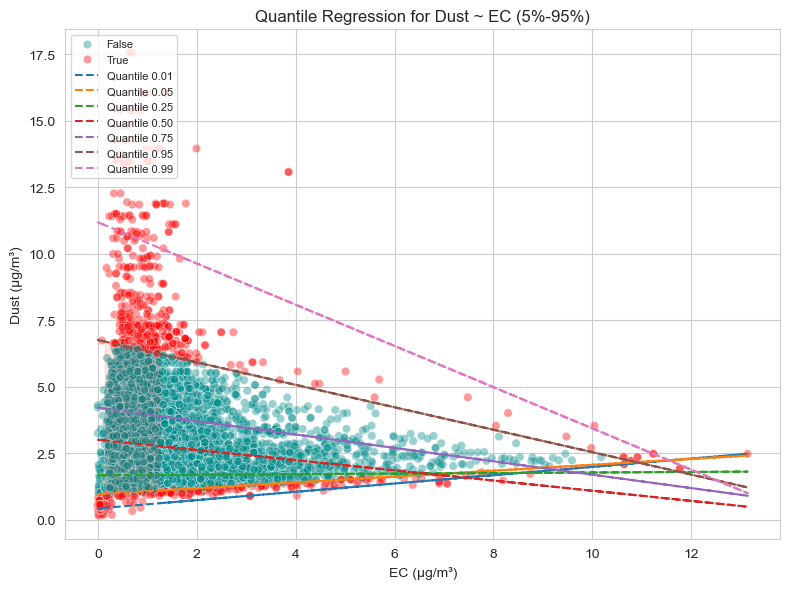

Based on 5%-95% quantile bounds:
 - Total data points analyzed: 8253
 - Number of outliers detected: 826
Based on 1%-99% quantile bounds:
 - Total data points analyzed: 8253
 - Number of outliers detected: 167


In [128]:
# Prepare data
df_filtered = df_filtered.dropna(subset=["dust", "EC"]).copy()
X = sm.add_constant(df_filtered["EC"])
y = df_filtered["dust"]

# Quantiles to compute
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df_preds = pd.DataFrame({"EC": df_filtered["EC"]})

# Fit quantile regressions
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    df_preds[q] = model.predict(X)

# Compute bounds and outliers
df_filtered["Lower_05_95_dust"] = df_preds[0.05]
df_filtered["Upper_05_95_dust"] = df_preds[0.95]
df_filtered["Outlier_05_95_dust"] = (
    (df_filtered["dust"] < df_filtered["Lower_05_95_dust"]) |
    (df_filtered["dust"] > df_filtered["Upper_05_95_dust"])
)

df_filtered["Lower_01_99_dust"] = df_preds[0.01]
df_filtered["Upper_01_99_dust"] = df_preds[0.99]
df_filtered["Outlier_01_99_dust"] = (
    (df_filtered["dust"] < df_filtered["Lower_01_99_dust"]) |
    (df_filtered["dust"] > df_filtered["Upper_01_99_dust"])
)

# Plot result (5%-95% only)
plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.scatterplot(
    ax=ax, x=df_filtered["EC"], y=df_filtered["dust"],
    hue=df_filtered["Outlier_05_95_dust"], palette={True: "red", False: "darkcyan"},
    alpha=0.4
)
for q in quantiles:
    ax.plot(df_preds["EC"], df_preds[q], linestyle="dashed", label=f"Quantile {q:.2f}")
ax.fill_between(df_preds["EC"], df_preds[0.05], df_preds[0.95], color='red', alpha=0.1)
ax.set_title("Quantile Regression for Dust ~ EC (5%-95%)")
ax.set_xlabel("EC (µg/m³)")
ax.set_ylabel("Dust (µg/m³)")
ax.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# Summary of outlier detection results
total_points_dust = len(df_filtered)

num_outliers_05_95_dust = df_filtered["Outlier_05_95_dust"].sum()
percent_outliers_05_95_dust = (num_outliers_05_95_dust / total_points_dust) * 100

num_outliers_01_99_dust = df_filtered["Outlier_01_99_dust"].sum()
percent_outliers_01_99_dust = (num_outliers_01_99_dust / total_points_dust) * 100

print("Based on 5%-95% quantile bounds:")
print(f" - Total data points analyzed: {total_points_dust}")
print(f" - Number of outliers detected: {num_outliers_05_95_dust}")

print("Based on 1%-99% quantile bounds:")
print(f" - Total data points analyzed: {total_points_dust}")
print(f" - Number of outliers detected: {num_outliers_01_99_dust}")

Let's remove the previously detected outliers and add as columns values needed later to model our concentrations.

In [130]:
# Filter by Quantile Regression 1%-99% for BC
df_filtered = df_filtered[(~df_filtered["Outlier_01_99_BC"])].copy()

# Filter by Quantile Regression 1%-99% for Aerosols
df_filtered = df_filtered[(~df_filtered["Outlier_01_99_aerosols"])].copy()

# Filter by Quantile Regression 1%-99% for Dust
df_filtered = df_filtered[(~df_filtered["Outlier_01_99_dust"])].copy()

# Keep only valid rows to avoid division by zero or log of non-positive values)
df_filtered = df_filtered[(df_filtered["EC"] > 0) & (df_filtered["BC"] > 0)  & (df_filtered["aerosols"] > 0) & (df_filtered["dust"] > 0)].copy()

# Create BC/EC
df_filtered['BC_EC_ratio'] = df_filtered['BC'] / df_filtered['EC']

# Create log(BC/EC)
df_filtered['log_BC_EC_ratio'] = np.log(df_filtered['BC'] / df_filtered['EC'])

# Compute secondary aerosol sum over EC ratio
df_filtered['aerosols_EC_ratio'] = df_filtered['aerosols'] / df_filtered['EC']

# Compute secondary aerosol sum over EC log ratio
df_filtered['log_aerosols_EC_ratio'] = np.log(df_filtered['aerosols'] / df_filtered['EC'])

# Compute dust over EC ratio
df_filtered['dust_EC_ratio'] = df_filtered['dust'] / df_filtered['EC']

# Compute dust over EC log ratio
df_filtered['log_dust_EC_ratio'] = np.log(df_filtered['dust'] / df_filtered['EC'])

# Print results
print(f"Number of resulting rows: {len(df_filtered)}")
display(df_filtered.head())

Number of resulting rows: 7823


,Station_name,ID,Latitude,Longitude,Datetime,BC,EC,Protocol,Instrument_EC,Instrument_BC,...,Outlier_05_95_dust,Lower_01_99_dust,Upper_01_99_dust,Outlier_01_99_dust,BC_EC_ratio,log_BC_EC_ratio,aerosols_EC_ratio,log_aerosols_EC_ratio,dust_EC_ratio,log_dust_EC_ratio
42,Hyytiälä-SMEAR II,ID133,61.847,24.295,2017-12-31,0.162558,0.1390,EUSAAR,LVol_Filters,MAAP,...,True,0.447662,11.078980,False,1.169482,0.156561,53.237410,3.974761,6.090445,1.806721
44,Birkenes II Observatory,ID123,58.389,8.252,2017-11-11,0.030480,0.0315,EUSAAR,LVol_Filters,MAAP,...,True,0.430868,11.162295,False,0.967628,-0.032908,27.206349,3.303450,17.007962,2.833682
60,Birkenes II Observatory,ID123,58.389,8.252,2018-03-03,0.162665,0.0950,EUSAAR,LVol_Filters,MAAP,...,True,0.440788,11.113081,False,1.712267,0.537818,40.989474,3.713315,5.917429,1.777902
62,Birkenes II Observatory,ID123,58.389,8.252,2018-03-17,0.092447,0.0600,EUSAAR,LVol_Filters,MAAP,...,True,0.435320,11.140207,False,1.540785,0.432292,25.016667,3.219542,8.072337,2.088443
64,Birkenes II Observatory,ID123,58.389,8.252,2018-03-31,0.168405,0.0750,EUSAAR,LVol_Filters,MAAP,...,False,0.437664,11.128581,False,2.245402,0.808884,93.480000,4.537748,16.442760,2.799885


We can display the number of observations per bin for each ratio to see if outliers are still present.

In [132]:
# Define the ratios and number of bins
ratios = ["BC_EC_ratio", "aerosols_EC_ratio", "dust_EC_ratio"]
n_bins = 30

# Loop through each ratio and compute histogram counts
for col in ratios:
    data = df_filtered[col].dropna()
    counts, bin_edges = np.histogram(data, bins=n_bins)
    
    print(f"\nHistogram for {col} ({n_bins} bins):")
    for i in range(len(counts)):
        print(f"Bin {i+1}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}) → {counts[i]} observations")


Histogram for BC_EC_ratio (30 bins):
Bin 1: [0.30, 44.08) → 7822 observations
Bin 2: [44.08, 87.85) → 0 observations
Bin 3: [87.85, 131.62) → 0 observations
Bin 4: [131.62, 175.40) → 0 observations
Bin 5: [175.40, 219.17) → 0 observations
Bin 6: [219.17, 262.94) → 0 observations
Bin 7: [262.94, 306.71) → 0 observations
Bin 8: [306.71, 350.49) → 0 observations
Bin 9: [350.49, 394.26) → 0 observations
Bin 10: [394.26, 438.03) → 0 observations
Bin 11: [438.03, 481.81) → 0 observations
Bin 12: [481.81, 525.58) → 0 observations
Bin 13: [525.58, 569.35) → 0 observations
Bin 14: [569.35, 613.13) → 0 observations
Bin 15: [613.13, 656.90) → 0 observations
Bin 16: [656.90, 700.67) → 0 observations
Bin 17: [700.67, 744.45) → 0 observations
Bin 18: [744.45, 788.22) → 0 observations
Bin 19: [788.22, 831.99) → 0 observations
Bin 20: [831.99, 875.76) → 0 observations
Bin 21: [875.76, 919.54) → 0 observations
Bin 22: [919.54, 963.31) → 0 observations
Bin 23: [963.31, 1007.08) → 0 observations
Bin 24:

The previously created code allowed us to detect the normal range of each of the three ratios. Let's remove the abnormal observations that were kept after the deletion allowed by the quantile regression of 1%-99%.

In [136]:
# Delete lines that are obviously considered outliers
df_filtered = df_filtered[df_filtered['BC_EC_ratio'] < 10].copy()
df_filtered = df_filtered[df_filtered['aerosols_EC_ratio'] < 200].copy()
df_filtered = df_filtered[df_filtered['dust_EC_ratio'] < 65].copy()

Now, let's create a grid to display the distribution (histogram + density curve) of the shape of the original ratios versus their log-transformed versions.

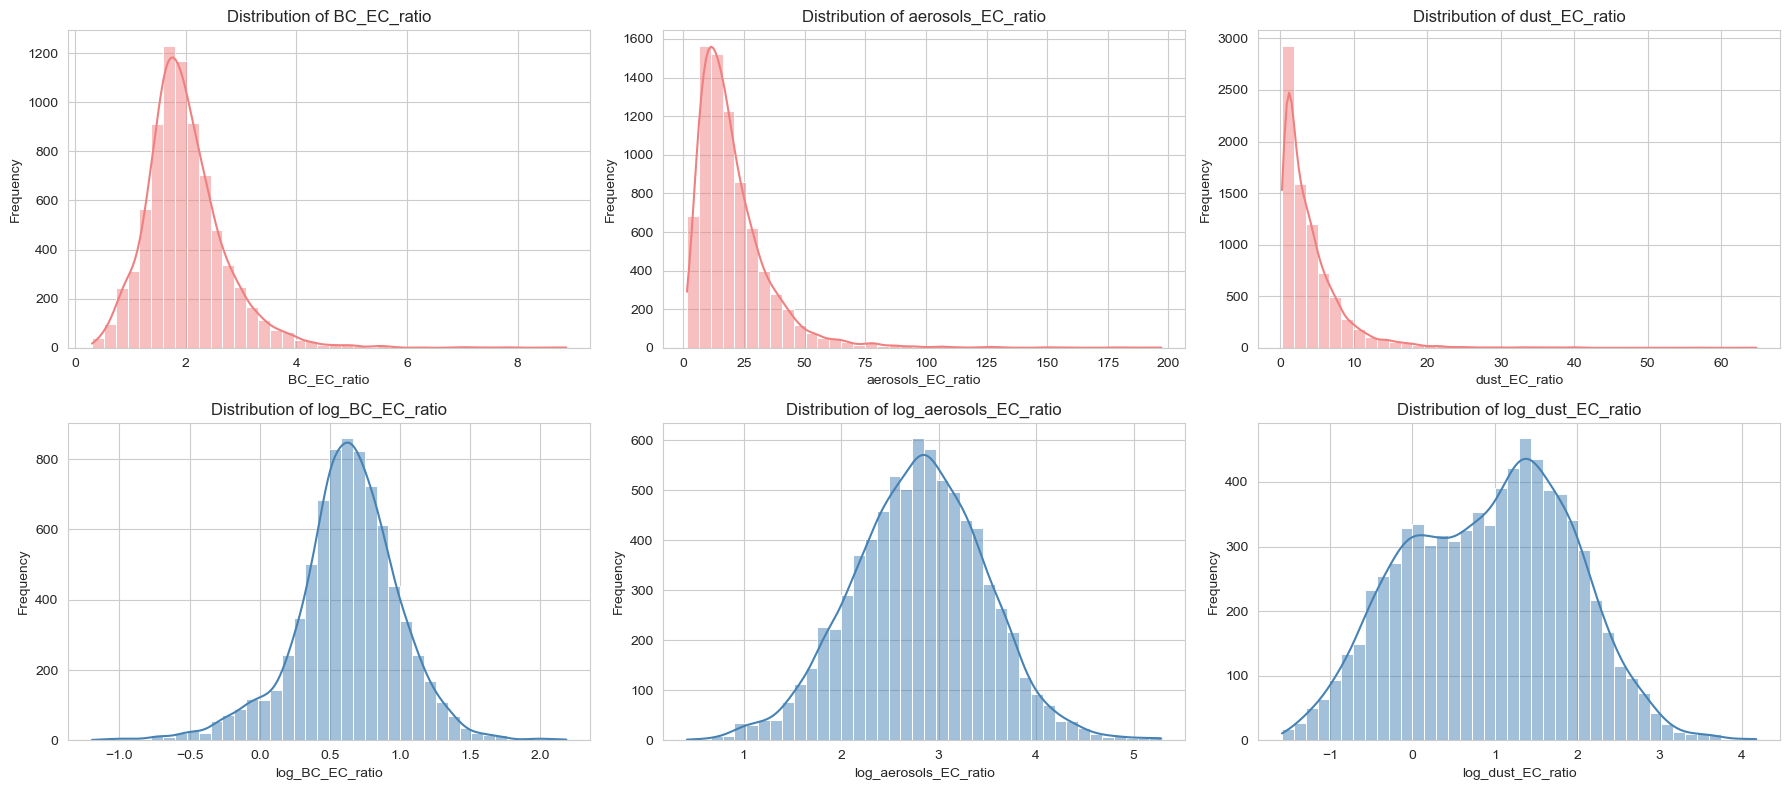

In [138]:
# Define the ratio and log-ratio columns
ratios = ["BC_EC_ratio", "aerosols_EC_ratio", "dust_EC_ratio"]
log_ratios = ["log_BC_EC_ratio", "log_aerosols_EC_ratio", "log_dust_EC_ratio"]

# Create a 2-row, 3-column grid for the plots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# First row: raw ratios
for i, col in enumerate(ratios):
    sns.histplot(df_filtered[col].dropna(), kde=True, bins=40, ax=axes[0, i], color='lightcoral')
    axes[0, i].set_title(f"Distribution of {col}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")

# Second row: log-transformed ratios
for i, col in enumerate(log_ratios):
    sns.histplot(df_filtered[col].dropna(), kde=True, bins=40, ax=axes[1, i], color='steelblue')
    axes[1, i].set_title(f"Distribution of {col}")
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel("Frequency")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

And, once again, as we did before the outliers detection, let's look at the average value (in µg/m³) of each component in addition to its % contribution for each aerosol concentration measurement. 

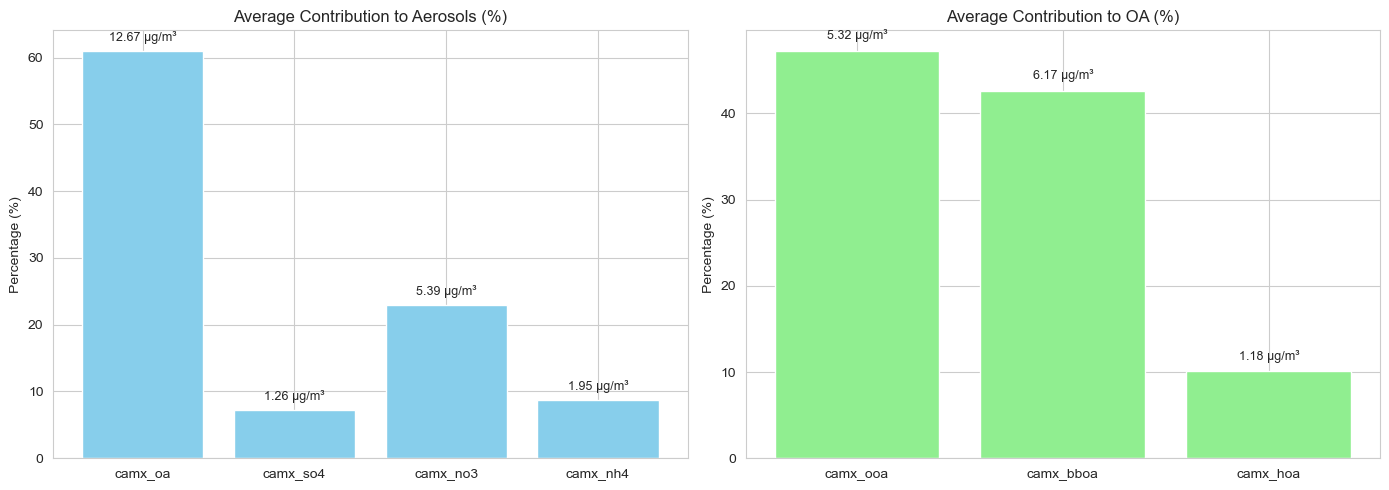

In [140]:
# Define component lists
aerosol_components = ['camx_oa', 'camx_so4', 'camx_no3', 'camx_nh4']
oa_components = ['camx_ooa', 'camx_bboa', 'camx_hoa']

# Calculate percentage contribution to aerosols
df_aero_ratio = df_filtered[aerosol_components].div(df_filtered['aerosols'], axis=0) * 100
mean_contrib_aero = df_aero_ratio.mean()
mean_values_aero = df_filtered[aerosol_components].mean()

# Calculate percentage contribution to camx_oa
df_oa_ratio = df_filtered[oa_components].div(df_filtered['camx_oa'], axis=0) * 100
mean_contrib_oa = df_oa_ratio.mean()
mean_values_oa = df_filtered[oa_components].mean()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Aerosols
bars1 = axes[0].bar(mean_contrib_aero.index, mean_contrib_aero.values, color='skyblue')
axes[0].set_title("Average Contribution to Aerosols (%)")
axes[0].set_ylabel("Percentage (%)")
axes[0].grid(True, axis='y')

# Annotate with absolute values
for bar, value in zip(bars1, mean_values_aero.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{value:.2f} µg/m³", ha='center', va='bottom', fontsize=9)

# Plot 2: camx_oa
bars2 = axes[1].bar(mean_contrib_oa.index, mean_contrib_oa.values, color='lightgreen')
axes[1].set_title("Average Contribution to OA (%)")
axes[1].set_ylabel("Percentage (%)")
axes[1].grid(True, axis='y')

# Annotate with absolute values
for bar, value in zip(bars2, mean_values_oa.values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{value:.2f} µg/m³", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

As we clearly see, the camx_ooa values are consistently much higher than both camx_bboa and camx_hoa. This is what causes the total camx_oa (which I define as their sum) to dominate over the other secondary aerosol components like camx_no3, camx_so4, and camx_nh4. This leads to the situation where the total (OA + SO₄ + NO₃ + NH₄) is heavily driven by the OA component, much higher than compared to BC. 

Now, we aim to evaluate whether biases in BC measurements relative to EC (expressed as log(BC/EC)) are related to the relative abundance of secondary aerosols. These aerosols include OA (organic aerosol), NO₃⁻, SO₄²⁻, and NH₄⁺, all extracted from CAMx model outputs. The hypothesis is that higher secondary aerosol loading may lead to BC overestimation (e.g. due to optical absorption by non-BC material), and that this may manifest in a systematic relationship between: log(BC / EC) (as dependent variable) and (OA + SO₄ + NO₃ + NH₄) / EC (as predictor)

To explore this, we visualize the distribution of both log-ratios via histograms, and perform a median quantile regression of BC and Aerosols with respect to EC, to compare their respective trends.

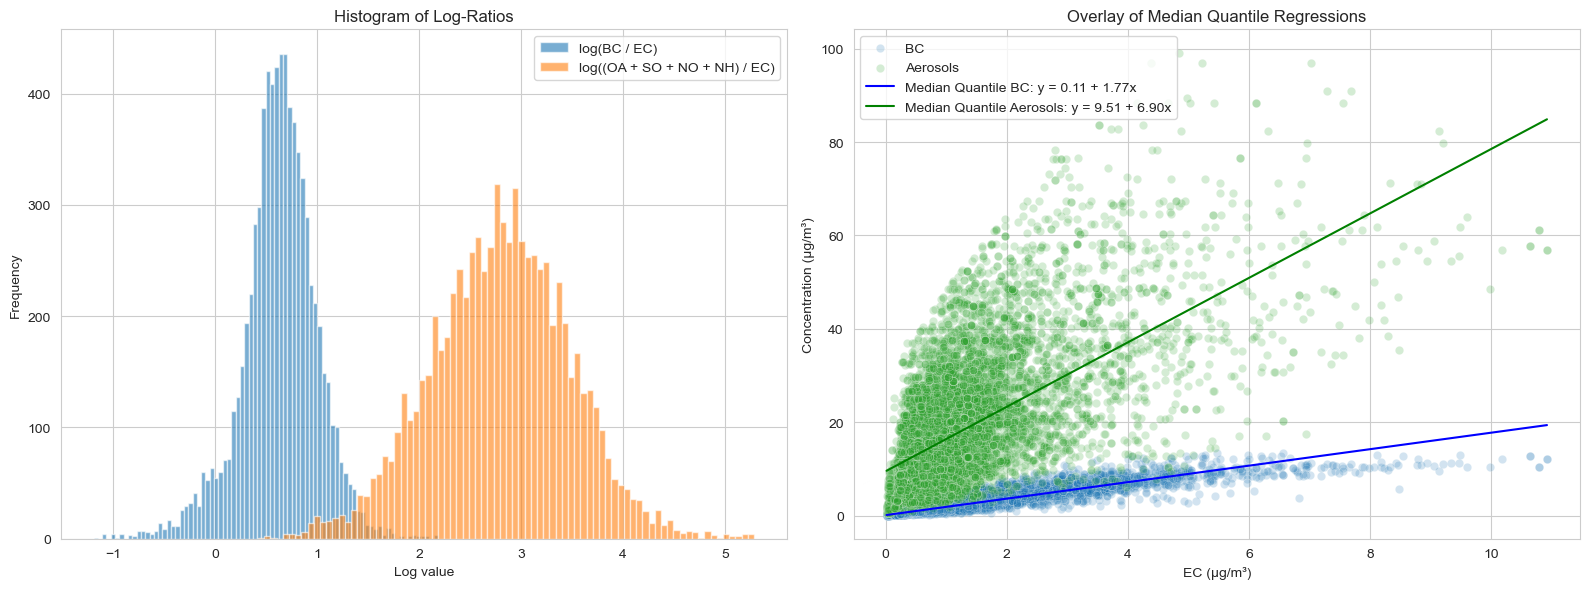

In [144]:
import statsmodels.formula.api as smf

# Drop rows with missing values
df_qr = df_filtered.dropna(subset=["EC", "BC", "aerosols", "log_BC_EC_ratio", "log_aerosols_EC_ratio"]).copy()

# Set up figure with 2 plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of log-ratios
axes[0].hist(df_qr['log_BC_EC_ratio'], bins=80, alpha=0.6, label='log(BC / EC)', color='tab:blue')
axes[0].hist(df_qr['log_aerosols_EC_ratio'], bins=80, alpha=0.6, label='log((OA + SO + NO + NH) / EC)', color='tab:orange')
axes[0].set_title("Histogram of Log-Ratios")
axes[0].set_xlabel("Log value")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

# Overlay of Quantile Regressions

# Define range for EC
x_vals = np.linspace(df_qr['EC'].min(), df_qr['EC'].max(), 100)

# Quantile Regression: BC ~ EC
qr_bc = smf.quantreg("BC ~ EC", df_qr).fit(q=0.5)
intercept_bc, slope_bc = qr_bc.params
y_bc = intercept_bc + slope_bc * x_vals

# Quantile Regression: Aerosols ~ EC
qr_aero = smf.quantreg("aerosols ~ EC", df_qr).fit(q=0.5)
intercept_aero, slope_aero = qr_aero.params
y_aero = intercept_aero + slope_aero * x_vals

# Plot data points
sns.scatterplot(data=df_qr, x="EC", y="BC", alpha=0.2, label="BC", color="tab:blue", ax=axes[1])
sns.scatterplot(data=df_qr, x="EC", y="aerosols", alpha=0.2, label="Aerosols", color="tab:green", ax=axes[1])

# Overlay quantile regression lines
axes[1].plot(x_vals, y_bc, color='blue', label=f"Median Quantile BC: y = {intercept_bc:.2f} + {slope_bc:.2f}x")
axes[1].plot(x_vals, y_aero, color='green', label=f"Median Quantile Aerosols: y = {intercept_aero:.2f} + {slope_aero:.2f}x")

axes[1].set_title("Overlay of Median Quantile Regressions")
axes[1].set_xlabel("EC (µg/m³)")
axes[1].set_ylabel("Concentration (µg/m³)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In the left panel, we observe that the distribution of log((OA + SO₄ + NO₃ + NH₄)/EC) is significantly shifted to the right compared to log(BC/EC), confirming that the aerosol/EC ratio is generally much larger than BC/EC.

In the right panel, the quantile regression lines show that BC increases gradually with EC, with a low slope (≈1.77), however, aerosols show a much steeper increase (≈6.90), starting from a higher intercept as well. This suggests that for a given EC, the secondary aerosol burden is disproportionately higher compared to BC, especially as EC increases. 

We can see, directly from the data, that the OA (especially OOA) heavily drives the variability in total aerosol, potentially introducing biases into BC measurements if optical methods are sensitive to non-BC absorbers.

The next objective is to examine whether the presence of large quantities of secondary aerosols (particularly OA, SO₄²⁻, NO₃⁻, and NH₄⁺) can influence the measurement of Black Carbon (BC) relative to Elemental Carbon (EC), represented by log(BC/EC). We hypothesize that BC may be overestimated as the concentration of secondary aerosols increases. This overestimation is thought to stem from the fact that some optical instruments are sensitive to other absorbing particles (such as OOA), which would bias the BC measurement.

To explore this hypothesis, we constructed two essential variables:
- log(BC / EC), which expresses the difference between the two measurements on a logarithmic scale; this is our dependent variable, representing the relative bias between the measurements.
- (OA + SO₄ + NO₃ + NH₄) / EC, or the ratio between the total secondary aerosol load and the EC, our explanatory variable, which measures the potential influence of secondary pollution.

To model a potential nonlinear relationship, we can visualize the relationship using a scatter plot and a two-order polynomial regression (simple spline). A third-order spline allows us to model relationships that increase rapidly, slow down, or even stabilize or decrease, whereas a linear relationship would be too rigid, and we expect a non-constant effect of the aerosol on BC. This is therefore a flexible first approach to exploring the shape of the relationship.

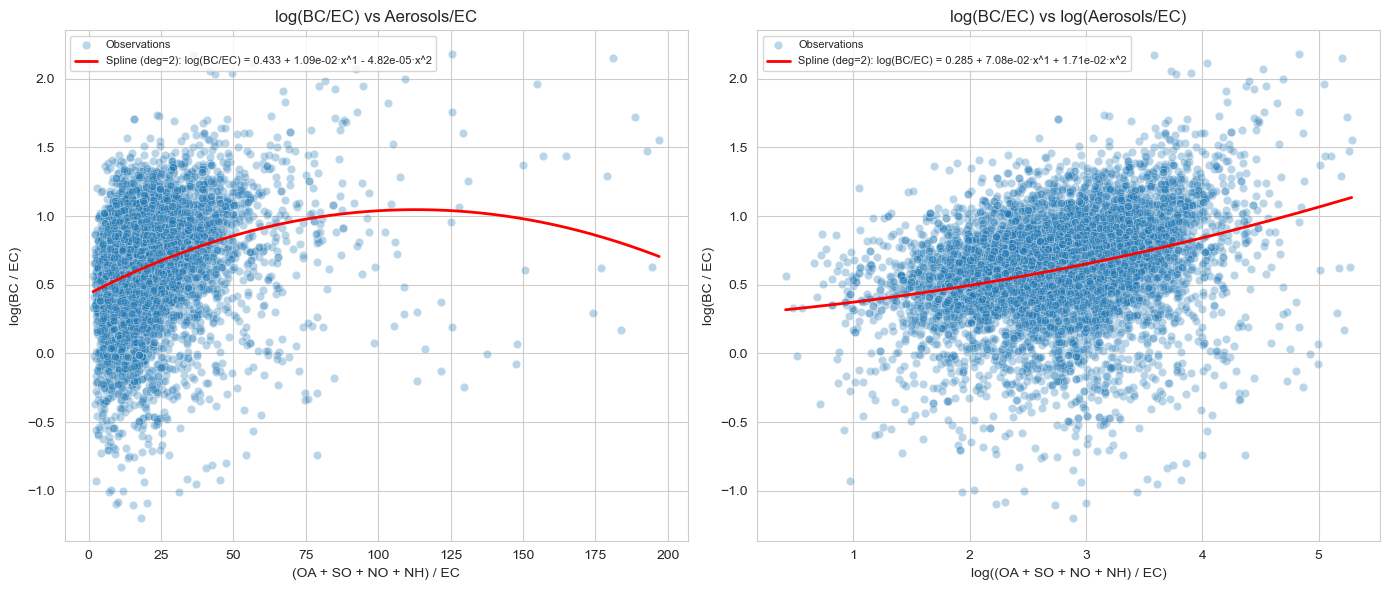

In [148]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Clean the data (remove inf and NaN)
df_plot = df_filtered.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    'log_BC_EC_ratio', 'aerosols_EC_ratio', 'log_aerosols_EC_ratio'
])

# Create a 1-row, 2-column plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# --------- 1st plot: log(BC/EC) vs aerosols_EC_ratio ---------
X1 = df_plot['aerosols_EC_ratio'].values.reshape(-1, 1)
y1 = df_plot['log_BC_EC_ratio'].values

poly1 = PolynomialFeatures(degree=2)
X1_poly = poly1.fit_transform(X1)

model1 = LinearRegression()
model1.fit(X1_poly, y1)

intercept1 = model1.intercept_
coeffs1 = model1.coef_

equation1 = f"log(BC/EC) = {intercept1:.3f}"
for i, c in enumerate(coeffs1[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation1 += f" {sign} {abs(c):.2e}·x^{i}"

X1_fit = np.linspace(X1.min(), X1.max(), 500).reshape(-1, 1)
y1_fit = model1.predict(poly1.transform(X1_fit))

sns.scatterplot(x='aerosols_EC_ratio', y='log_BC_EC_ratio', data=df_plot, alpha=0.3, ax=axes[0], label='Observations')
axes[0].plot(X1_fit, y1_fit, color='red', linewidth=2, label=f"Spline (deg=2): {equation1}")
axes[0].set_title("log(BC/EC) vs Aerosols/EC")
axes[0].set_xlabel("(OA + SO + NO + NH) / EC")
axes[0].set_ylabel("log(BC / EC)")
axes[0].legend(loc="upper left", fontsize=8)
axes[0].grid(True)

# --------- 2nd plot: log(BC/EC) vs log(aerosols_EC_ratio) ---------
X2 = df_plot['log_aerosols_EC_ratio'].values.reshape(-1, 1)
y2 = df_plot['log_BC_EC_ratio'].values

poly2 = PolynomialFeatures(degree=2)
X2_poly = poly2.fit_transform(X2)

model2 = LinearRegression()
model2.fit(X2_poly, y2)

intercept2 = model2.intercept_
coeffs2 = model2.coef_

equation2 = f"log(BC/EC) = {intercept2:.3f}"
for i, c in enumerate(coeffs2[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation2 += f" {sign} {abs(c):.2e}·x^{i}"

X2_fit = np.linspace(X2.min(), X2.max(), 500).reshape(-1, 1)
y2_fit = model2.predict(poly2.transform(X2_fit))

sns.scatterplot(x='log_aerosols_EC_ratio', y='log_BC_EC_ratio', data=df_plot, alpha=0.3, ax=axes[1], label='Observations')
axes[1].plot(X2_fit, y2_fit, color='red', linewidth=2, label=f"Spline (deg=2): {equation2}")
axes[1].set_title("log(BC/EC) vs log(Aerosols/EC)")
axes[1].set_xlabel("log((OA + SO + NO + NH) / EC)")
axes[1].set_ylabel("log(BC / EC)")
axes[1].legend(loc="upper left", fontsize=8)
axes[1].grid(True)

# Layout
plt.tight_layout()
plt.show()

The graph shows:
- A clear increasing trend between (OA + SO₄ + NO₃ + NH₄) / EC and log(BC / EC) in the densely populated areas of the graph (low to moderate ratio values).
- This trend clearly reflects the potential bias in BC measurements as the secondary aerosol load increases.
- Above a certain threshold, the curve begins to stabilize, but this area is very sparsely populated (sparse, more uncertain data).

This behavior is consistent with a saturation of the effect: beyond a certain aerosol level, the marginal impact on BC measurements becomes small, or reflects statistical noise. These results confirm the central hypothesis of our project: The presence of secondary aerosols tends to distort BC measurements, resulting in an increase in log(BC/EC). The relationship is nonlinear, as the effect is stronger at low pollution levels (where the EC is low) and then flattens out.

Conclusion:
- There is a significant relationship, consistent with our physical expectations, between the secondary aerosol ratio and the BC/EC bias.
- The spline shape (increasing curve with saturation) is physically interpretable and makes sense of the data.
- This analysis reinforces the idea that BC corrections based on secondary aerosol loading are justified, particularly for optical instruments sensitive to aerosols.

After visually observing an increasing trend between the ratio (OA + SO₄ + NO₃ + NH₄) / EC and log(BC / EC), we wish to statistically verify whether this relationship is significant. The idea is to validate that this correlation is not due to chance and that there is indeed a measurable dependence.

We use the Spearman correlation test, a non-parametric method that tests whether there is a monotonic (increasing or decreasing) relationship between two quantitative variables, without assuming normality or linearity. This test is particularly well-suited to our context:
- The visually observed relationship appears increasing but non-linear,
- The data exhibit asymmetries and extreme values, which makes robust tests like Spearman's more reliable than Pearson's.

In [156]:
from scipy.stats import spearmanr

# 1. Spearman correlation: log_BC_EC_ratio vs aerosols_EC_ratio
df_corr1 = df_filtered.dropna(subset=['log_BC_EC_ratio', 'aerosols_EC_ratio'])
corr1, pval1 = spearmanr(df_corr1['aerosols_EC_ratio'], df_corr1['log_BC_EC_ratio'])

print("Spearman correlation: log(BC/EC) vs Aerosols/EC")
print(f"-  Correlation = {corr1:.3f}")
print(f"-  P-value     = {pval1:.2e}\n")

# 2. Spearman correlation: log_BC_EC_ratio vs log_aerosols_EC_ratio
df_corr2 = df_filtered.dropna(subset=['log_BC_EC_ratio', 'log_aerosols_EC_ratio'])
corr2, pval2 = spearmanr(df_corr2['log_aerosols_EC_ratio'], df_corr2['log_BC_EC_ratio'])

print("Spearman correlation: log(BC/EC) vs log(Aerosols/EC)")
print(f"-  Correlation = {corr2:.3f}")
print(f"-  P-value     = {pval2:.2e}")

Spearman correlation: log(BC/EC) vs Aerosols/EC
-  Correlation = 0.324
-  P-value     = 1.08e-189

Spearman correlation: log(BC/EC) vs log(Aerosols/EC)
-  Correlation = 0.324
-  P-value     = 1.08e-189


The test reveals a positive correlation, indicating a moderate and highly significant increasing relationship between secondary aerosol load relative to EC and log(BC/EC).

We can deepen this analysis by exploring how the ratio log(BC/EC) varies as a function of secondary aerosols, represented by the variables:
- (OA + SO + NO + NH) / EC, the raw ratio.
- log((OA + SO + NO + NH) / EC), the log-transformed ratio.

To understand the structure of the relationship, we apply two modeling techniques on both representations:
- Polynomial Regression (degree 2): A quadratic fit to model the general trend and provide an interpretable equation.
- Smoothing Spline: A flexible, non-parametric curve that adapts to the local structure of the data without assuming a specific functional form. This helps capture subtle nonlinearities or changes in curvature.

The spline is a piecewise-defined polynomial function that is continuous and smooth across intervals. It is especially useful when the data do not follow a predefined shape (like a line or parabola). The version we use here is a smoothing spline, computed via the UnivariateSpline method from scipy.interpolate. This method balances two objectives, fidelity to data by minimizing the distance between the curve and the observed points, and Smoothness by avoiding overfitting by penalizing excessive curvature. Under the hood, the spline is constructed from polynomial segments joined at points called knots. These knots define where one polynomial piece ends and the next begins, and they are chosen automatically. The s parameter controls the degree of smoothing by allowing the curve to deviate more or less from the data. A small s forces the spline to follow the data closely (many wiggles), while a large s results in a much smoother curve. The smoothing parameter chosen is s = n, where n is the number of points used for the spline. This produces a curve smooth enough to capture the trend, without overfitting.

Both models are plotted together for visual comparison. The red curve represents the degree-2 polynomial regression with its corresponding equation. The green curve shows the fitted spline. By combining these two models, the polynomial for global trend and the spline for local adaptation, we obtain a richer and more nuanced understanding of the relationship between aerosols and the BC/EC ratio. 

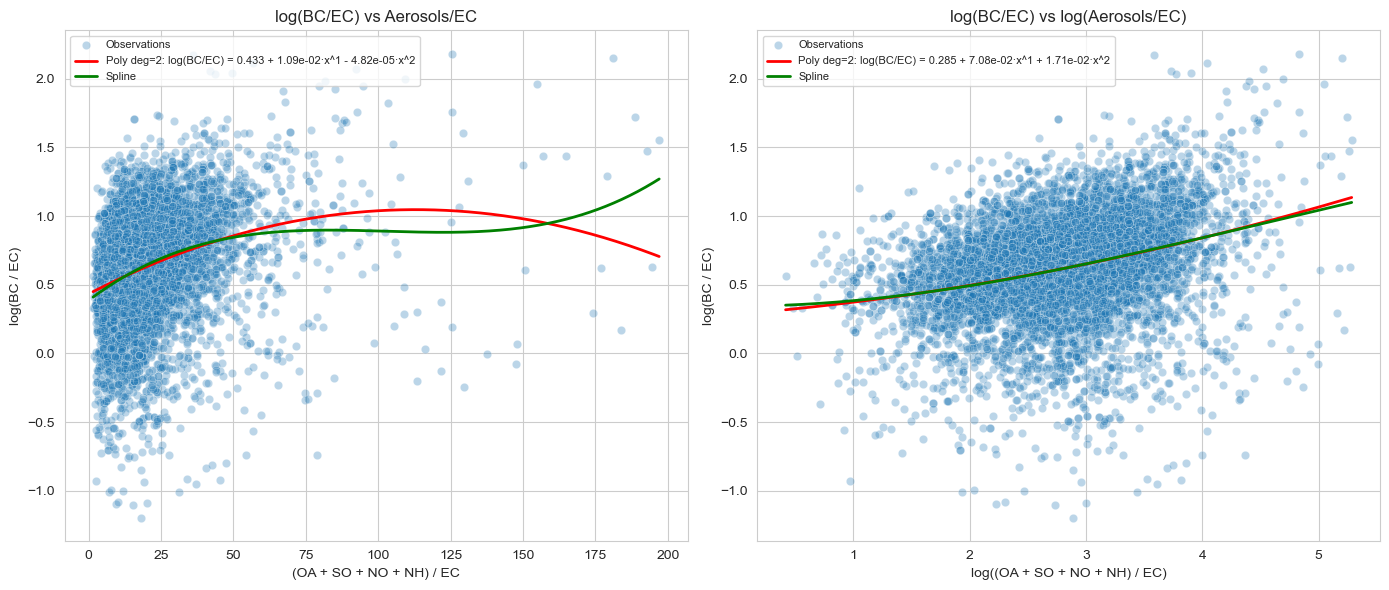

In [161]:
from scipy.interpolate import UnivariateSpline

# Clean the data (remove inf and NaN)
df_plot = df_filtered.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    'log_BC_EC_ratio', 'aerosols_EC_ratio', 'log_aerosols_EC_ratio'
])

# Create a 1-row, 2-column plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# --------- 1st plot: log(BC/EC) vs aerosols_EC_ratio ---------
X1_raw = df_plot['aerosols_EC_ratio'].values
y1_raw = df_plot['log_BC_EC_ratio'].values

# Polynomial fit
X1 = X1_raw.reshape(-1, 1)
poly1 = PolynomialFeatures(degree=2)
X1_poly = poly1.fit_transform(X1)
model1 = LinearRegression()
model1.fit(X1_poly, y1_raw)

intercept1 = model1.intercept_
coeffs1 = model1.coef_
equation1 = f"log(BC/EC) = {intercept1:.3f}"
for i, c in enumerate(coeffs1[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation1 += f" {sign} {abs(c):.2e}·x^{i}"

X1_fit = np.linspace(X1_raw.min(), X1_raw.max(), 500).reshape(-1, 1)
y1_fit = model1.predict(poly1.transform(X1_fit))

# Spline
sort_idx1 = np.argsort(X1_raw)
X1_sorted = X1_raw[sort_idx1]
y1_sorted = y1_raw[sort_idx1]
spline1 = UnivariateSpline(X1_sorted, y1_sorted, s=len(X1_sorted))
y1_spline = spline1(X1_fit.flatten())

# Plot
sns.scatterplot(x=X1_raw, y=y1_raw, alpha=0.3, ax=axes[0], label='Observations')
axes[0].plot(X1_fit, y1_fit, color='red', linewidth=2, label=f"Poly deg=2: {equation1}")
axes[0].plot(X1_fit, y1_spline, color='green', linewidth=2, label='Spline')
axes[0].set_title("log(BC/EC) vs Aerosols/EC")
axes[0].set_xlabel("(OA + SO + NO + NH) / EC")
axes[0].set_ylabel("log(BC / EC)")
axes[0].legend(loc="upper left", fontsize=8)
axes[0].grid(True)

# --------- 2nd plot: log(BC/EC) vs log(aerosols_EC_ratio) ---------
X2_raw = df_plot['log_aerosols_EC_ratio'].values
y2_raw = df_plot['log_BC_EC_ratio'].values

# Polynomial fit
X2 = X2_raw.reshape(-1, 1)
poly2 = PolynomialFeatures(degree=2)
X2_poly = poly2.fit_transform(X2)
model2 = LinearRegression()
model2.fit(X2_poly, y2_raw)

intercept2 = model2.intercept_
coeffs2 = model2.coef_
equation2 = f"log(BC/EC) = {intercept2:.3f}"
for i, c in enumerate(coeffs2[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation2 += f" {sign} {abs(c):.2e}·x^{i}"

X2_fit = np.linspace(X2_raw.min(), X2_raw.max(), 500).reshape(-1, 1)
y2_fit = model2.predict(poly2.transform(X2_fit))

# Spline
sort_idx2 = np.argsort(X2_raw)
X2_sorted = X2_raw[sort_idx2]
y2_sorted = y2_raw[sort_idx2]
spline2 = UnivariateSpline(X2_sorted, y2_sorted, s=len(X2_sorted))
y2_spline = spline2(X2_fit.flatten())

# Plot
sns.scatterplot(x=X2_raw, y=y2_raw, alpha=0.3, ax=axes[1], label='Observations')
axes[1].plot(X2_fit, y2_fit, color='red', linewidth=2, label=f"Poly deg=2: {equation2}")
axes[1].plot(X2_fit, y2_spline, color='green', linewidth=2, label='Spline')
axes[1].set_title("log(BC/EC) vs log(Aerosols/EC)")
axes[1].set_xlabel("log((OA + SO + NO + NH) / EC)")
axes[1].set_ylabel("log(BC / EC)")
axes[1].legend(loc="upper left", fontsize=8)
axes[1].grid(True)

# Layout
plt.tight_layout()
plt.show()

The left plot shows the relationship between log(BC/EC) and the raw ratio (OA + SO + NO + NH) / EC.  The polynomial fit (red) suggests a concave-down quadratic pattern: log(BC/EC) increases with secondary aerosols until a point (~100), then slightly decreases. However, the smoothing spline (green) captures more subtle variations, showing a slight upturn at very high aerosol concentrations. This indicates potential nonlinear behavior not fully captured by the quadratic model.

The right plot depicts the relationship using the log-transformed ratio. Here, both the polynomial and the spline reveal a more linear or gently increasing relationship. The fit is more stable across the range, and the spline closely follows the polynomial curve, suggesting a robust positive association in the log-log space.

Let us now explore whether mineral dust concentrations have an impact on the ratio between Black Carbon (BC) and Elemental Carbon (EC). The hypothesis is that:
- Dust, as absorbing particles, could influence optical instruments and cause an overestimation of BC, which would increase the BC/EC ratio.

We therefore use a second-order polynomial spline (i.e., a quadratic regression) to model the potentially nonlinear relationship between dust (explanatory variable) and log(BC/EC) (target variable). The spline approach allows for the capture of smooth trends, including a non-constant effect or saturation.

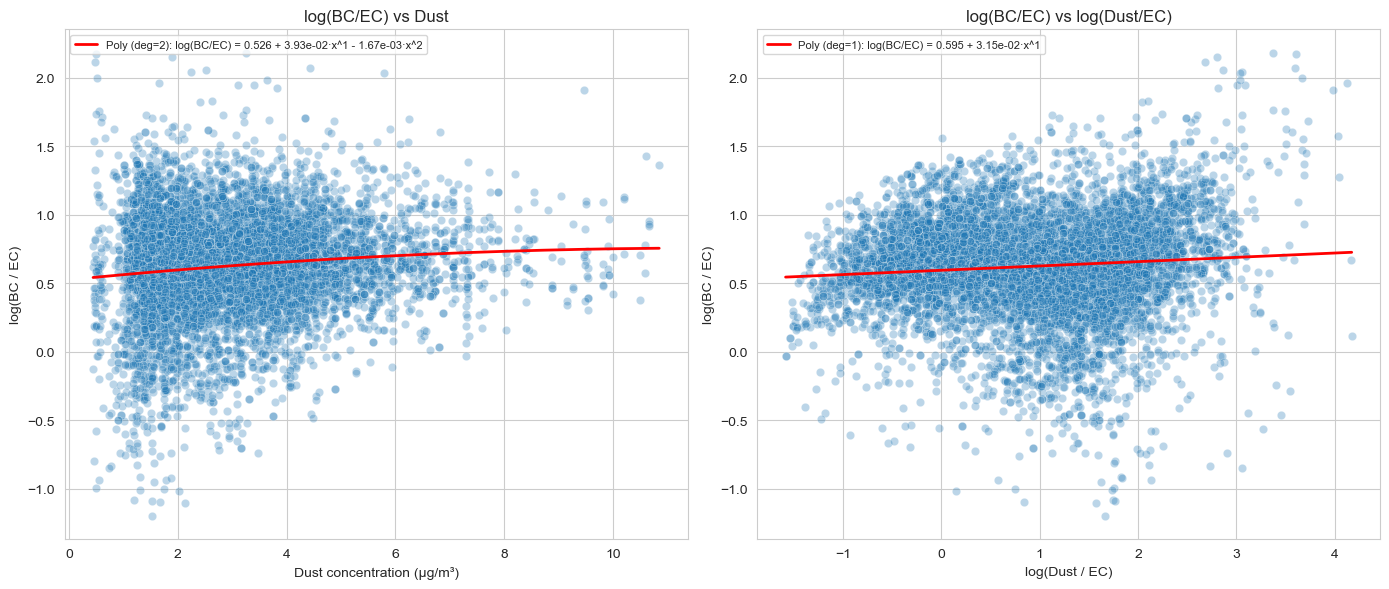

In [237]:
# Filter valid rows
df_plot_dust = df_filtered.replace([np.inf, -np.inf], np.nan).dropna(
    subset=['log_BC_EC_ratio', 'dust', 'dust_EC_ratio']
)

# Create a 1-row, 2-column plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --------- 1st plot: log(BC/EC) vs dust ---------
X1_raw = df_plot_dust['dust'].values
y1_raw = df_plot_dust['log_BC_EC_ratio'].values

# Polynomial fit (deg=2)
X1 = X1_raw.reshape(-1, 1)
poly1 = PolynomialFeatures(degree=2)
X1_poly = poly1.fit_transform(X1)
model1 = LinearRegression()
model1.fit(X1_poly, y1_raw)

intercept1 = model1.intercept_
coeffs1 = model1.coef_
equation1 = f"log(BC/EC) = {intercept1:.3f}"
for i, c in enumerate(coeffs1[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation1 += f" {sign} {abs(c):.2e}·x^{i}"

X1_fit = np.linspace(X1_raw.min(), X1_raw.max(), 500).reshape(-1, 1)
y1_fit = model1.predict(poly1.transform(X1_fit))

# Plot (spline removed)
sns.scatterplot(x='dust', y='log_BC_EC_ratio', data=df_plot_dust, alpha=0.3, ax=axes[0])
axes[0].plot(X1_fit, y1_fit, color='red', linewidth=2, label=f"Poly (deg=2): {equation1}")
axes[0].set_title("log(BC/EC) vs Dust")
axes[0].set_xlabel("Dust concentration (µg/m³)")
axes[0].set_ylabel("log(BC / EC)")
axes[0].legend(loc="upper left", fontsize=8)
axes[0].grid(True)

# --------- 2nd plot: log(BC/EC) vs log(dust/EC) ---------
log_dust_ec_ratio = np.log(df_plot_dust['dust_EC_ratio'].values)
X2_raw = log_dust_ec_ratio
y2_raw = df_plot_dust['log_BC_EC_ratio'].values

# Polynomial fit (deg=2)
X2 = X2_raw.reshape(-1, 1)
poly2 = PolynomialFeatures(degree=1)
X2_poly = poly2.fit_transform(X2)
model2 = LinearRegression()
model2.fit(X2_poly, y2_raw)

intercept2 = model2.intercept_
coeffs2 = model2.coef_
equation2 = f"log(BC/EC) = {intercept2:.3f}"
for i, c in enumerate(coeffs2[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation2 += f" {sign} {abs(c):.2e}·x^{i}"

X2_fit = np.linspace(X2_raw.min(), X2_raw.max(), 500).reshape(-1, 1)
y2_fit = model2.predict(poly2.transform(X2_fit))

# Plot (spline removed)
sns.scatterplot(x=log_dust_ec_ratio, y='log_BC_EC_ratio', data=df_plot_dust, alpha=0.3, ax=axes[1])
axes[1].plot(X2_fit, y2_fit, color='red', linewidth=2, label=f"Poly (deg=1): {equation2}")
axes[1].set_title("log(BC/EC) vs log(Dust/EC)")
axes[1].set_xlabel("log(Dust / EC)")
axes[1].set_ylabel("log(BC / EC)")
axes[1].legend(loc="upper left", fontsize=8)
axes[1].grid(True)

# Final layout
plt.tight_layout()
plt.show()

# Alternative version with splines (hidden by adding `if False:`)
if False:
    # Filter valid rows
    df_plot_dust = df_filtered.replace([np.inf, -np.inf], np.nan).dropna(
        subset=['log_BC_EC_ratio', 'dust', 'dust_EC_ratio']
    )
    
    # Create 1-row, 2-column plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # --------- 1st plot: log(BC/EC) vs dust ---------
    X1_raw = df_plot_dust['dust'].values
    y1_raw = df_plot_dust['log_BC_EC_ratio'].values
    
    # Polynomial regression (deg=2)
    X1 = X1_raw.reshape(-1, 1)
    poly1 = PolynomialFeatures(degree=2)
    X1_poly = poly1.fit_transform(X1)
    model1 = LinearRegression().fit(X1_poly, y1_raw)
    
    intercept1 = model1.intercept_
    coeffs1 = model1.coef_
    equation1 = f"log(BC/EC) = {intercept1:.3f}"
    for i, c in enumerate(coeffs1[1:], start=1):
        sign = "+" if c >= 0 else "-"
        equation1 += f" {sign} {abs(c):.2e}·x^{i}"
    
    # Fit for plotting
    X1_fit = np.linspace(X1_raw.min(), X1_raw.max(), 500).reshape(-1, 1)
    y1_fit = model1.predict(poly1.transform(X1_fit))
    
    # Spline
    sort_idx1 = np.argsort(X1_raw)
    X1_sorted = X1_raw[sort_idx1]
    y1_sorted = y1_raw[sort_idx1]
    spline1 = UnivariateSpline(X1_sorted, y1_sorted, s=len(X1_sorted))
    y1_spline = spline1(X1_fit.flatten())
    
    # Plot
    sns.scatterplot(x=X1_raw, y=y1_raw, alpha=0.3, ax=axes[0], label='Observations')
    axes[0].plot(X1_fit, y1_fit, color='red', linewidth=2, label=f"Poly (deg=2): {equation1}")
    axes[0].plot(X1_fit, y1_spline, color='green', linewidth=2, label='Spline')
    axes[0].set_title("log(BC/EC) vs Dust")
    axes[0].set_xlabel("Dust concentration (µg/m³)")
    axes[0].set_ylabel("log(BC / EC)")
    axes[0].legend(loc="upper left", fontsize=8)
    axes[0].grid(True)
    
    # --------- 2nd plot: log(BC/EC) vs log(dust/EC) ---------
    log_dust_ec_ratio = np.log(df_plot_dust['dust_EC_ratio'].values)
    y2_raw = df_plot_dust['log_BC_EC_ratio'].values
    
    # Polynomial regression (deg=1)
    X2 = log_dust_ec_ratio.reshape(-1, 1)
    poly2 = PolynomialFeatures(degree=1)
    X2_poly = poly2.fit_transform(X2)
    model2 = LinearRegression().fit(X2_poly, y2_raw)
    
    intercept2 = model2.intercept_
    coeffs2 = model2.coef_
    equation2 = f"log(BC/EC) = {intercept2:.3f}"
    for i, c in enumerate(coeffs2[1:], start=1):
        sign = "+" if c >= 0 else "-"
        equation2 += f" {sign} {abs(c):.2e}·x^{i}"
    
    # Fit for plotting
    X2_fit = np.linspace(np.nanmin(log_dust_ec_ratio), np.nanmax(log_dust_ec_ratio), 500).reshape(-1, 1)
    y2_fit = model2.predict(poly2.transform(X2_fit))
    
    # Spline (valid only)
    valid_idx = ~np.isnan(log_dust_ec_ratio) & ~np.isinf(log_dust_ec_ratio) & ~np.isnan(y2_raw)
    X2_clean = log_dust_ec_ratio[valid_idx]
    y2_clean = y2_raw[valid_idx]
    
    sort_idx2 = np.argsort(X2_clean)
    X2_sorted = X2_clean[sort_idx2]
    y2_sorted = y2_clean[sort_idx2]
    spline2 = UnivariateSpline(X2_sorted, y2_sorted, s=len(X2_sorted))
    y2_spline = spline2(X2_fit.flatten())
    
    # Plot
    sns.scatterplot(x=log_dust_ec_ratio, y=y2_raw, alpha=0.3, ax=axes[1], label='Observations')
    axes[1].plot(X2_fit, y2_fit, color='red', linewidth=2, label=f"Poly (deg=1): {equation2}")
    axes[1].plot(X2_fit, y2_spline, color='green', linewidth=2, label='Spline')
    axes[1].set_title("log(BC/EC) vs log(Dust/EC)")
    axes[1].set_xlabel("log(Dust / EC)")
    axes[1].set_ylabel("log(BC / EC)")
    axes[1].legend(loc="upper left", fontsize=8)
    axes[1].grid(True)
    
    # Final layout
    plt.tight_layout()
    plt.show()

The two plots above illustrate how log(BC/EC) varies with respect to dust concentration and dust over EC ratio. In both cases, a polynomial regression of degree 2 is used to model the trend. Let’s interpret each graph.

The first scatter plot shows a relatively dense and homogeneous distribution of log(BC/EC) observations around a mean value, with little apparent slope. The fitted polynomial curve is slightly increasing at first and then tends to stabilize. The obtained equation shows that the effect of dust is small but not zero. Let's analyze the coefficients:
- Intercept (0.508): represents the theoretical mean value of log(BC/EC) when the dust concentration is zero.
- Coefficient of x (1.36×10^−2): suggests a small initial upward slope.
- Coefficient of x^2 (−1.44×10^−4): indicates that the increase decelerates, so the effect of dust slows down as it increases (the curve is concave).

These coefficients are very small in absolute value, meaning that even if there is a weak upward trend, dust concentration influence is moderate or even marginal on the target variable log(BC/EC). The relationship between dust concentrations and the BC/EC bias is visually very weak, but not completely flat. The effect appears positive (BC/EC increases slightly with dust), but the magnitude is minimal. The curve does not reveal any strong or visually striking relationship between dust and log(BC/EC), but a gentle, increasing trend is still present. This justifies further testing for statistical significance. Thus, the effect of dust exists, but it is weak; it can be detected statistically, but does not have a major impact on log(BC/EC) values in the majority of cases.

This second graph shows a slightly clearer trend. As dust/EC increases, log(BC/EC) also increases more significantly, as the curve increases more steeply than in the previous graph, and the positive coefficients suggest an acceleration of the upward trend. Thus, the second graph reveals a slightly stronger association between dust and the BC/EC bias once normalized by EC. Therefore, using the dust/EC ratio amplifies the trend, likely because it normalizes the variability of EC and better reflects the relative influence of dust. This supports the idea that higher dust concentrations (especially relative to EC) can slightly increase BC/EC, which is tantamount to saying that higher dust concentrations increase BC concentrations.

The Spearman test assesses whether there is a monotonic relationship between two variables. This allows us to statistically test whether the relationship between dust concentration and log(BC / EC) is significant, since the relationship appears weak and potentially nonlinear, and the Spearman correlation test assumes neither linearity nor normality.

In [170]:
# Filter rows with no missing values
df_corr_dust = df_filtered.dropna(subset=['log_BC_EC_ratio', 'dust', 'dust_EC_ratio'])

# --- 1. Spearman correlation: log(BC/EC) vs dust ---
corr1, pval1 = spearmanr(df_corr_dust['dust'], df_corr_dust['log_BC_EC_ratio'])
print("Spearman correlation: log(BC/EC) vs Dust")
print(f"-  Correlation = {corr1:.3f}")
print(f"-  P-value     = {pval1:.2e}\n")

# --- 2. Spearman correlation: log(BC/EC) vs log(Dust/EC) ---
log_dust_ec_ratio = np.log(df_corr_dust['dust_EC_ratio'])
corr2, pval2 = spearmanr(log_dust_ec_ratio, df_corr_dust['log_BC_EC_ratio'])
print("Spearman correlation: log(BC/EC) vs log(Dust/EC)")
print(f"-  Correlation = {corr2:.3f}")
print(f"-  P-value     = {pval2:.2e}")

Spearman correlation: log(BC/EC) vs Dust
-  Correlation = 0.088
-  P-value     = 8.56e-15

Spearman correlation: log(BC/EC) vs log(Dust/EC)
-  Correlation = 0.074
-  P-value     = 5.60e-11


We can conclude that there is indeed a significant positive monotonic correlation between dust and log(BC / EC). Although the coefficient value is low (~0.102), the p-value indicates that this relationship is statistically robust across the sample. This means that as dust concentration increases, the BC / EC ratio increases slightly, which is consistent with the idea that, to some extent, BC is marginally biased upwards in the presence of absorbing dust.

A marginal effect refers to a weak, secondary, or small-scale impact of an explanatory variable on a dependent variable. It is not a null effect, nor random noise, but rather a real effect, statistically detectable (as here with a p-value < 0.001), but which explains little variance in the target variable, and which does not have strong predictive power on its own.

To go further in the analysis of aerosols concentrations, we examine the relationship between Black Carbon (BC) concentrations and the combined concentration of two secondary inorganic aerosols: nitrate (NO₃) and sulfate (SO₄). These secondary aerosols, often formed through atmospheric chemical reactions, can be indicative of regional pollution processes and may affect the observed BC concentrations.

To model this relationship, we:
- Compute the sum of camx_no3 and camx_so4 for each observation to form a new variable: (NO₃ + SO₄).
- Fit a polynomial regression of degree 2 to predict BC as a function of this combined variable. This choice allows capturing potential nonlinearities in the relationship.
- Display both the data and the fitted curve in a scatter plot.

This plot aims to visually assess whether an increasing concentration of these aerosols is associated with higher or lower levels of BC.

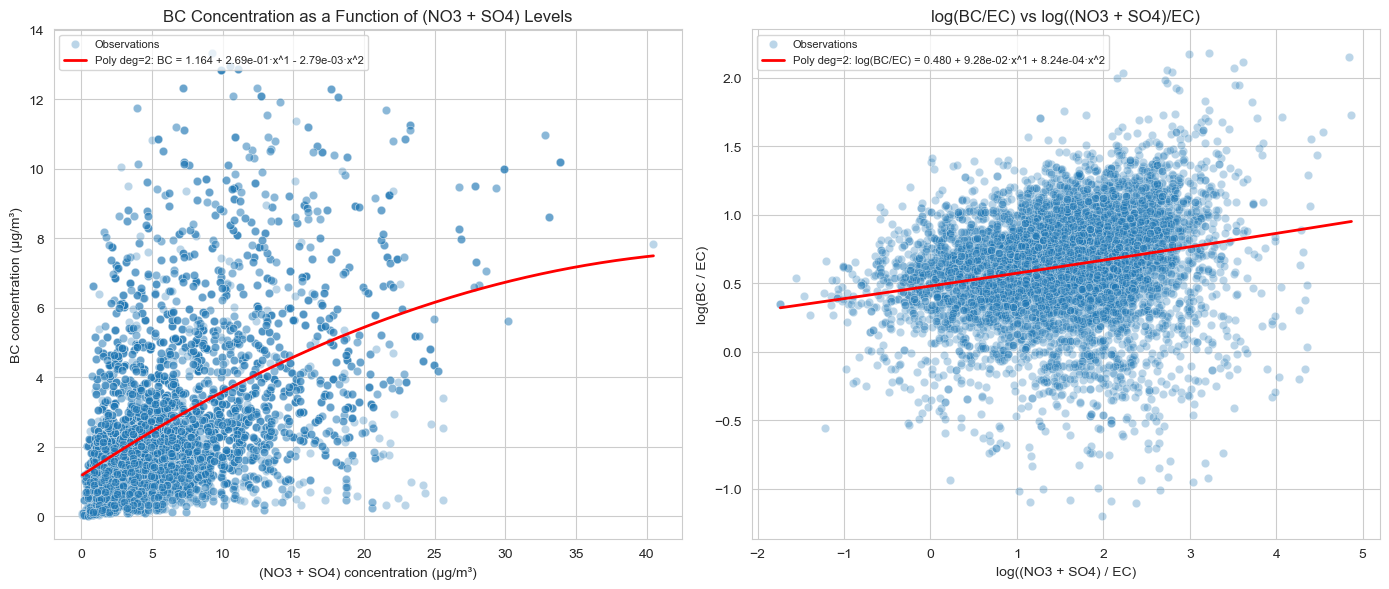

In [104]:
# Clean and prepare data
df_plot = df_filtered.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    'BC', 'camx_no3', 'camx_so4', 'EC', 'log_BC_EC_ratio'
])
df_plot['no3_so4_sum'] = df_plot['camx_no3'] + df_plot['camx_so4']
df_plot['log_no3_so4_EC_ratio'] = np.log(df_plot['no3_so4_sum'] / df_plot['EC'])

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

### -------- LEFT: BC vs (NO3 + SO4) --------
X1 = df_plot['no3_so4_sum'].values.reshape(-1, 1)
y1 = df_plot['BC'].values

poly1 = PolynomialFeatures(degree=2)
X1_poly = poly1.fit_transform(X1)
model1 = LinearRegression().fit(X1_poly, y1)

intercept1 = model1.intercept_
coeffs1 = model1.coef_
equation1 = f"BC = {intercept1:.3f}"
for i, c in enumerate(coeffs1[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation1 += f" {sign} {abs(c):.2e}·x^{i}"

X1_fit = np.linspace(X1.min(), X1.max(), 500).reshape(-1, 1)
y1_fit = model1.predict(poly1.transform(X1_fit))

sns.scatterplot(x='no3_so4_sum', y='BC', data=df_plot, alpha=0.3, ax=axes[0], label="Observations")
axes[0].plot(X1_fit, y1_fit, color='red', linewidth=2, label=f"Poly deg=2: {equation1}")
axes[0].set_title("BC Concentration as a Function of (NO3 + SO4) Levels")
axes[0].set_xlabel("(NO3 + SO4) concentration (µg/m³)")
axes[0].set_ylabel("BC concentration (µg/m³)")
axes[0].legend(loc="upper left", fontsize=8)
axes[0].grid(True)

### -------- RIGHT: log(BC/EC) vs log((NO3 + SO4)/EC) --------
X2 = df_plot['log_no3_so4_EC_ratio'].values.reshape(-1, 1)
y2 = df_plot['log_BC_EC_ratio'].values

poly2 = PolynomialFeatures(degree=2)
X2_poly = poly2.fit_transform(X2)
model2 = LinearRegression().fit(X2_poly, y2)

intercept2 = model2.intercept_
coeffs2 = model2.coef_
equation2 = f"log(BC/EC) = {intercept2:.3f}"
for i, c in enumerate(coeffs2[1:], start=1):
    sign = "+" if c >= 0 else "-"
    equation2 += f" {sign} {abs(c):.2e}·x^{i}"

X2_fit = np.linspace(X2.min(), X2.max(), 500).reshape(-1, 1)
y2_fit = model2.predict(poly2.transform(X2_fit))

sns.scatterplot(x='log_no3_so4_EC_ratio', y='log_BC_EC_ratio', data=df_plot, alpha=0.3, ax=axes[1], label="Observations")
axes[1].plot(X2_fit, y2_fit, color='red', linewidth=2, label=f"Poly deg=2: {equation2}")
axes[1].set_title("log(BC/EC) vs log((NO3 + SO4)/EC)")
axes[1].set_xlabel("log((NO3 + SO4) / EC)")
axes[1].set_ylabel("log(BC / EC)")
axes[1].legend(loc="upper left", fontsize=8)
axes[1].grid(True)

plt.tight_layout()
plt.show()

The resulting plot shows a dense cloud of observations for low to moderate values of (NO₃ + SO₄), with BC concentrations ranging primarily from 0 to 6 µg/m³. The red regression curve provides a smooth fit that highlights the overall trend in the data. From the fitted equation:
- The positive coefficient for x suggests that BC tends to increase with rising concentrations of NO₃ + SO₄.
- The negative coefficient for x² indicates that the relationship may level off or saturate at higher aerosol levels, suggesting diminishing marginal effects.

This non-linear behavior may reflect the fact that BC emissions are only partly related to secondary aerosol levels, and that other sources or meteorological factors may influence BC independently. Overall, the regression confirms a moderate positive association between secondary inorganic aerosols and BC, though with considerable dispersion.

In the right-hand plot, we explore a related but normalized relationship: log(BC/EC) vs log((NO₃ + SO₄)/EC). This transformation helps account for the effect of EC as a baseline and evaluates whether BC is increasingly overestimated relative to EC as the aerosol load grows. The polynomial regression line again reveals a positive trend, though more linear and consistent across the range, with a much smaller quadratic term. This suggests a steadier increase in BC/EC bias as the ratio of secondary aerosols to EC increases.

Together, the two plots suggest that:
- BC concentration increases with the presence of NO₃ and SO₄, but this effect tapers off at high concentrations.
- When adjusted for EC, the log(BC/EC) ratio still increases with aerosol loading, reinforcing the idea that secondary aerosols may influence optical BC measurements, potentially through co-absorption or instrument bias.

These findings support the hypothesis that secondary inorganic aerosols are associated with higher measured BC levels, either directly or indirectly, and that this association persists even after normalizing for EC.

To assess the strength and significance of the linear relationship between black carbon (BC) concentration and the sum of nitrate (NO₃) and sulfate (SO₄) concentrations, we perform a Pearson correlation test. This test quantifies the linear association between two continuous variables and provides both a correlation coefficient (r) and a p-value to evaluate statistical significance.

In [107]:
from scipy.stats import pearsonr

# Filter valid values
df_corr = df_plot.dropna(subset=['BC', 'no3_so4_sum', 'log_BC_EC_ratio', 'log_no3_so4_EC_ratio'])

### --- 1. BC vs (NO3 + SO4) ---
pearson_raw, pval_pearson_raw = pearsonr(df_corr['no3_so4_sum'], df_corr['BC'])
spearman_raw, pval_spearman_raw = spearmanr(df_corr['no3_so4_sum'], df_corr['BC'])

print("Correlation: BC vs (NO₃ + SO₄)")
print(f"- Pearson  r = {pearson_raw:.3f}, p = {pval_pearson_raw:.2e}")
print(f"- Spearman r = {spearman_raw:.3f}, p = {pval_spearman_raw:.2e}\n")

### --- 2. log(BC/EC) vs log((NO3 + SO4)/EC) ---
pearson_log, pval_pearson_log = pearsonr(df_corr['log_no3_so4_EC_ratio'], df_corr['log_BC_EC_ratio'])
spearman_log, pval_spearman_log = spearmanr(df_corr['log_no3_so4_EC_ratio'], df_corr['log_BC_EC_ratio'])

print("Correlation: log(BC/EC) vs log((NO₃ + SO₄)/EC)")
print(f"- Pearson  r = {pearson_log:.3f}, p = {pval_pearson_log:.2e}")
print(f"- Spearman r = {spearman_log:.3f}, p = {pval_spearman_log:.2e}")


Correlation: BC vs (NO₃ + SO₄)
- Pearson  r = 0.482, p = 0.00e+00
- Spearman r = 0.504, p = 0.00e+00

Correlation: log(BC/EC) vs log((NO₃ + SO₄)/EC)
- Pearson  r = 0.223, p = 1.42e-88
- Spearman r = 0.255, p = 2.22e-116


We performed both Pearson and Spearman correlation tests to quantify the strength and significance of the relationships between:
- BC and the sum of nitrate and sulfate concentrations (NO₃ + SO₄).
- log(BC/EC) and log((NO₃ + SO₄)/EC).

These tests help us assess whether the observed relationships are statistically meaningful.

Correlation between BC and (NO₃ + SO₄) results indicates a moderate positive relationship between BC and the combined concentrations of nitrate and sulfate. Both correlation coefficients are highly significant (p < 0.001), suggesting that as NO₃ + SO₄ increases, BC concentration tends to increase as well. This result supports the idea that black carbon levels may co-vary with regional pollution levels, where secondary inorganic aerosols are also elevated.

Correlation between log(BC/EC) and log((NO₃ + SO₄)/EC) results, although weaker than the previous case, are still statistically significant and indicate a low-to-moderate positive association between the relative bias (log(BC/EC)) and the normalized aerosol load. This suggests that higher relative levels of secondary inorganic aerosols (compared to EC) are associated with an increase in the BC/EC ratio, potentially due to optical interference or measurement bias in BC detection.

This result suggests that as the combined concentrations of nitrate and sulfate increase, the concentration of black carbon tends to increase as well. Although this does not imply causality, it supports the idea that secondary inorganic aerosols might be associated with regions or periods of elevated BC levels, potentially due to common emission sources or atmospheric conditions that favor both species.